## Collecting Data

In [ ]:
import requests
from bs4 import BeautifulSoup
import os
import time

# Base URL for Danish language eBooks
base_url = "https://www.gutenberg.org/browse/languages/da"
save_dir = "Danish_texts"

os.makedirs(save_dir, exist_ok=True)

# Fetch the list of eBooks
response = requests.get(base_url)
if response.status_code != 200:
    print("Failed to fetch the eBooks page.")
    exit()

soup = BeautifulSoup(response.content, "html.parser")
book_links = []

# Extract links to individual eBook pages
for link in soup.find_all("a", href=True):
    if "/ebooks/" in link['href']:
        book_links.append("https://www.gutenberg.org" + link['href'])

# Download eBooks, excluding poetry
count = 0
for book_link in book_links:
    book_response = requests.get(book_link)
    book_soup = BeautifulSoup(book_response.content, "html.parser")

    # Check if the book is categorized as "Poetry"
    is_poetry = False
    for subject in book_soup.find_all("a", href=True):
        if "Poetry" in subject.text:
            is_poetry = True
            break

    if is_poetry:
        print(f"Skipping poetry book: {book_link}")
        continue

    # Look for txt UTF-8 format
    downloaded = False
    for download_link in book_soup.find_all("a", href=True):
        if "txt" in download_link['href']:
            download_url = "https://www.gutenberg.org" + download_link['href']
            file_name = download_url.split("/")[-1]
            file_path = os.path.join(save_dir, file_name)

            # Download the file
            print(f"Downloading {file_name}...")
            file_response = requests.get(download_url)
            with open(file_path, "wb") as f:
                f.write(file_response.content)
            print(f"Saved {file_name}")
            downloaded = True
            break

    if not downloaded:
        print(f"No downloadable formats found for {book_link}")

    print(f'{count}/{len(book_links)}')
    count += 1
    time.sleep(2)

print("All downloads completed.")

In [ ]:
import urllib.request
from bs4 import BeautifulSoup
import requests
from urllib.request import Request, urlopen
import tqdm
import glob
import pandas as pd
from IPython.display import clear_output
import os
import ebooklib
from ebooklib import epub
import sys
import codecs
#import mobi
from lxml.etree import XMLSyntaxError

In [ ]:
LANGUAGE = 'Lithuanian'
FORMATS = ['epub', 'txt']
ROOT_DIR = 'D:\\HSE\\I WILL BE THE BEST IN ML\\NLP course project Spot the Bot\\spot-the-bot-nlp-course-project'

PATH_TO_DATAFRAME = ROOT_DIR + '\\' + LANGUAGE + '_parsing_libgen.csv'

In [ ]:
df = pd.DataFrame(columns =['author', 'title', 'format', 'mirror0', 'mirror1', 'mirror2'])
for FORMAT in FORMATS:
  page = 1
  total_pages = None
  while True:
    #Get new page
    fp = urllib.request.urlopen('https://libgen.is/fiction/?q=&criteria=&language={language}&format={format}&page={page}'.format(language=LANGUAGE,
                                                                                                                                format=FORMAT,
                                                                                                                                page=page))
    mybytes = fp.read()
    mystr = mybytes.decode("utf8")
    fp.close()
    soup = BeautifulSoup(mystr, 'lxml')
    ####
    ##Checking if we reached the end
    if soup.find('table') is None:
      print('FINISHED FORMAT', FORMAT)
      print('IT IS THE END, LAST PAGE IS ', page - 1)
      print('TOTAL BOOKS', len(df))
      break

    #getting the number of pages
    if total_pages is None:
      page_selector= soup.find('span', {'class':'page_selector'})
      if page_selector is None:
        total_pages = 1
      else:
        total_pages = int(page_selector.get_text().split('/')[-1])

    #telling user that we are working
    clear_output()
    print('Parsing page {page} / {total_pages}'.format(page=page,
                                                       total_pages=total_pages))

    #Lets find all the rows corresponding to books
    all_books = soup.find('table').find_all('tr')
    for info in all_books[1:]:
      ##Parse information for every book
      author = info.find('a').text
      title = info.find('p').text
      #books in libgan.is has up to 3 mirrors links
      mirrors = [tag['href'] for tag in info.find('ul', attrs={'class': 'record_mirrors_compact'}).find_all('a')]
      new_row = {'author' : author,
                'title' : title,
                'format':FORMAT
                }
      for i in range(len(mirrors)):
        new_row['mirror' + str(i)] = mirrors[i]
      ###
      #df = df.append(new_row, ignore_index=True)
      df.loc[len(df)] = new_row
    page += 1

In [ ]:
#Now we have
df.sample(3)

In [ ]:
#save dataframe to some file
df.to_csv(PATH_TO_DATAFRAME)

In [ ]:
#load if you already have a dataframe
df = pd.read_csv(PATH_TO_DATAFRAME )

In [211]:
if not os.path.exists(ROOT_DIR):
    os.makedirs(ROOT_DIR)

FOLDER_FOR_EPUB = ROOT_DIR + '\\' + LANGUAGE + '_epub\\'
# FOLDER_FOR_MOBI = ROOT_DIR + '\\' + LANGUAGE + '_mobi\\'
# FOLDER_FOR_TXT  = ROOT_DIR + '\\' + LANGUAGE + '_txt\\'
# FOLDER_FOR_EPUB_TXT = ROOT_DIR + '\\' + LANGUAGE + '_epub_txt\\'
# FOLDER_FOR_MOBI_TXT = ROOT_DIR + '\\' + LANGUAGE + '_mobi_txt\\'
# FOLDER_FOR_MOBI_SIMPLE_NAMES = ROOT_DIR + '\\' + LANGUAGE + '_mobi_simple_names\\'



if not os.path.exists(FOLDER_FOR_EPUB):
    os.makedirs(FOLDER_FOR_EPUB)
# if not os.path.exists(FOLDER_FOR_MOBI):
#     os.makedirs(FOLDER_FOR_MOBI)
# if not os.path.exists(FOLDER_FOR_TXT):
#     os.makedirs(FOLDER_FOR_TXT)
# if not os.path.exists(FOLDER_FOR_EPUB_TXT):
#     os.makedirs(FOLDER_FOR_EPUB_TXT)
# if not os.path.exists(FOLDER_FOR_MOBI_TXT):
#     os.makedirs(FOLDER_FOR_MOBI_TXT)
# if not os.path.exists(FOLDER_FOR_MOBI_SIMPLE_NAMES):
#     os.makedirs(FOLDER_FOR_MOBI_SIMPLE_NAMES)

NameError: name 'ROOT_DIR' is not defined

In [ ]:
import time
#Firstly, let's save all epub files to the folder
for i in tqdm.tqdm(range(df.shape[0])):
  author = df.iloc[i]['author']
  title  = df.iloc[i]['title']
  if df.iloc[i]['format'] != 'epub':
    continue
  path_to_file = FOLDER_FOR_EPUB + '/' + author.replace(' ', '_') + '+' + title.replace(' ', '_').replace('/', '!') + '.epub'

  #If we have already downloaded the file, no need to do it again
  if os.path.exists(path_to_file):
    continue
  try:
        fout = open(path_to_file, 'w+')
  except OSError:
        continue
  
  time.sleep(1)

  for j in [0, 1, 2]:
    try:
      #Получаем зеркало
      fp = urllib.request.urlopen(df.iloc[i]['mirror' + str(j)])
      mybytes = fp.read()

      mystr = mybytes.decode("utf8")
      fp.close()
      soup = BeautifulSoup(mystr, 'lxml')
      if soup is None:
        continue

      #Link from GET
      new_ref = soup.find('h2').find('a')['href']
      #link from IPFS.io
      
      new_ref = None
      for a_tag in soup.find_all('a'):
        if a_tag.text == 'IPFS.io':
          new_ref = a_tag['href']
          break
      
      #######
      #Получили текст по ссылке
      r = requests.get(new_ref, stream=True)
      with open(path_to_file, 'wb') as f:
        f.write(r.content)

    except Exception as e:
      continue
    break

In [ ]:
import os
import ebooklib
from ebooklib import epub
from bs4 import BeautifulSoup

def convert_epub_to_txt(epub_path, txt_path):
    """
    Конвертирует EPUB-файл в TXT-файл.
    
    :param epub_path: Путь к EPUB-файлу
    :param txt_path: Путь для сохранения TXT-файла
    """
    try:
        # Загружаем EPUB-файл
        book = epub.read_epub(epub_path)
        
        # Извлекаем текст из всех глав
        text = []
        for item in book.get_items():
            if item.get_type() == ebooklib.ITEM_DOCUMENT:
                soup = BeautifulSoup(item.get_content(), 'html.parser')
                text.append(soup.get_text())
        
        # Объединяем текст и сохраняем в файл
        full_text = '\n'.join(text)
        with open(txt_path, 'w', encoding='utf-8') as f:
            f.write(full_text)
            
    except Exception as e:
        print(f"Ошибка при конвертации {epub_path}: {e}")

def convert_epubs_in_folder(input_folder, output_folder):
    """
    Конвертирует все EPUB-файлы из input_folder в TXT и сохраняет в output_folder.
    
    :param input_folder: Путь к папке с EPUB-файлами
    :param output_folder: Путь к папке для сохранения TXT-файлов
    """
    # Создаем выходную папку, если её нет
    os.makedirs(output_folder, exist_ok=True)
    
    # Обрабатываем все EPUB-файлы в папке
    for filename in os.listdir(input_folder):
        if filename.lower().endswith('.epub'):
            epub_path = os.path.join(input_folder, filename)
            txt_filename = os.path.splitext(filename)[0] + '.txt'
            txt_path = os.path.join(output_folder, txt_filename)
            
            print(f"Конвертация {filename}...")
            convert_epub_to_txt(epub_path, txt_path)
    
    print("Конвертация завершена!")


convert_epubs_in_folder('texts_lithuanian_epub', 'texts_lithuanian_human')

## Data Analysis

In [214]:
import os
import pandas as pd
from collections import defaultdict

# List of folders to analyze
folders = [
    'texts_danish_bot',
    'texts_danish_human',
    'texts_lithuanian_bot',
    'texts_lithuanian_human'
]

# Dictionary to store statistics
stats = defaultdict(dict)

for folder in folders:
    # Initialize metrics for current folder
    num_texts = 0
    char_counts = []
    word_counts = []
    
    # Read files in the folder
    for filename in os.listdir(folder):
        filepath = os.path.join(folder, filename)
        try:
            with open(filepath, 'r', encoding='utf-8') as file:
                content = file.read()
                
                # Count characters and words
                char_count = len(content)
                word_count = len(content.split())  # simple whitespace-based split
                
                char_counts.append(char_count)
                word_counts.append(word_count)
                num_texts += 1
        except Exception as e:
            print(f"Error reading {filepath}: {e}")
            
    
    # Calculate statistics if files were found
    if num_texts > 0:
        stats[folder]['Number of texts'] = num_texts
        
        # Character statistics
        stats[folder]['Max chars'] = max(char_counts)
        stats[folder]['Min chars'] = min(char_counts)
        stats[folder]['Avg chars'] = round(sum(char_counts) / num_texts, 2)
        
        # Word statistics
        stats[folder]['Max words'] = max(word_counts)
        stats[folder]['Min words'] = min(word_counts)
        stats[folder]['Avg words'] = round(sum(word_counts) / num_texts, 2)
    else:
        print(f"No text files found in {folder}")

# Create DataFrame
df = pd.DataFrame.from_dict(stats, orient='index')

# Reorder columns for better readability
column_order = [
    'Number of texts',
    'Max chars', 'Min chars', 'Avg chars',
    'Max words', 'Min words', 'Avg words'
]
df = df[column_order]

# Display the results
print("Text Statistics Summary:")
print(df)


df.to_csv('text_statistics.csv')

Text Statistics Summary:
                        Number of texts  Max chars  Min chars  Avg chars  \
texts_danish_bot                     11     119781      48523  101853.64   
texts_danish_human                   71     733652      21063  291658.55   
texts_lithuanian_bot                 15     122115      12633   99693.00   
texts_lithuanian_human               29    1321068       3749  343404.69   

                        Max words  Min words  Avg words  
texts_danish_bot            21670       8564   18629.73  
texts_danish_human         127707       3087   50137.86  
texts_lithuanian_bot        18416       1899   14950.27  
texts_lithuanian_human     185814        560   49315.55  


In [215]:
df

Number of texts  Max chars  Min chars  Avg chars  \
texts_danish_bot                     11     119781      48523  101853.64   
texts_danish_human                   71     733652      21063  291658.55   
texts_lithuanian_bot                 15     122115      12633   99693.00   
texts_lithuanian_human               29    1321068       3749  343404.69   

                        Max words  Min words  Avg words  
texts_danish_bot            21670       8564   18629.73  
texts_danish_human         127707       3087   50137.86  
texts_lithuanian_bot        18416       1899   14950.27  
texts_lithuanian_human     185814        560   49315.55

## Preprocessing

In [ ]:
%pip install stanza

   ---------------------------------------- 0.0/1.1 MB ? eta -:--:--
   --------- ------------------------------ 0.3/1.1 MB ? eta -:--:--
   ---------------------------------------- 1.1/1.1 MB 3.9 MB/s eta 0:00:00
   ---------------------------------------- 0.0/590.6 kB ? eta -:--:--
   ---------------------------------------- 590.6/590.6 kB 4.2 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import stanza
stanza.download('da', processors='tokenize,lemma,pos')
stanza.download('lt', processors='tokenize,lemma,pos')

2025-04-29 14:07:19 INFO: Downloaded file to C:\Users\rogoz\stanza_resources\resources.json
2025-04-29 14:07:19 INFO: Downloading these customized packages for language: da (Danish)...
| Processor       | Package      |
----------------------------------
| tokenize        | ddt          |
| pos             | ddt_charlm   |
| lemma           | ddt_nocharlm |
| backward_charlm | oscar        |
| forward_charlm  | oscar        |
| pretrain        | conll17      |

2025-04-29 14:07:19 INFO: File exists: C:\Users\rogoz\stanza_resources\da\tokenize\ddt.pt
2025-04-29 14:07:19 INFO: File exists: C:\Users\rogoz\stanza_resources\da\pos\ddt_charlm.pt
2025-04-29 14:07:19 INFO: File exists: C:\Users\rogoz\stanza_resources\da\lemma\ddt_nocharlm.pt
2025-04-29 14:07:19 INFO: File exists: C:\Users\rogoz\stanza_resources\da\backward_charlm\oscar.pt
2025-04-29 14:07:19 INFO: File exists: C:\Users\rogoz\stanza_resources\da\forward_charlm\oscar.pt
2025-04-29 14:07:20 INFO: File exists: C:\Users\rogoz\stanz

2025-04-29 14:07:20 INFO: Downloaded file to C:\Users\rogoz\stanza_resources\resources.json
2025-04-29 14:07:20 INFO: Downloading these customized packages for language: lt (Lithuanian)...
| Processor | Package          |
--------------------------------
| tokenize  | alksnis          |
| pos       | alksnis_nocharlm |
| lemma     | alksnis_nocharlm |
| pretrain  | fasttextwiki     |

2025-04-29 14:07:20 INFO: File exists: C:\Users\rogoz\stanza_resources\lt\tokenize\alksnis.pt
2025-04-29 14:07:20 INFO: File exists: C:\Users\rogoz\stanza_resources\lt\pos\alksnis_nocharlm.pt
2025-04-29 14:07:20 INFO: File exists: C:\Users\rogoz\stanza_resources\lt\lemma\alksnis_nocharlm.pt
2025-04-29 14:07:21 INFO: File exists: C:\Users\rogoz\stanza_resources\lt\pretrain\fasttextwiki.pt
2025-04-29 14:07:21 INFO: Finished downloading models and saved to C:\Users\rogoz\stanza_resources


In [ ]:
supported_languages = {'da', 'lt'}
manual_stopwords = {
        'da': {'og', 'i', 'at', 'for', 'det', 'en', 'er', 'som', 'på', 'den'},  
        'lt': {'ir', 'o', 'su', 'į', 'bei', 'arba', 'tačiau', 'kad', 'kur', 'tai'} 
    }

def preprocess_text(text, lang):
    if lang not in supported_languages:
        raise ValueError(f"Unsupported language: {lang}. Available: {', '.join(supported_languages)}")

    nlp = stanza.Pipeline(lang, processors='tokenize,lemma,pos', download_method=None)
    doc = nlp(text)
    stopwords = manual_stopwords.get(lang, set())
    
    return [
        word.lemma.lower()
        for sent in doc.sentences
        for word in sent.words
        if word.upos not in ('PUNCT', 'SYM') and  
        word.lemma.lower() not in stopwords
    ]

In [ ]:
examples = [
    ("Dette er en dansk tekst med, punktum!", 'da'),
    ("Tai yra lietuviškas tekstas su kableliais!", 'lt')
]

for text, lang in examples:
    processed = preprocess_text(text, lang)
    print(f"\nLanguage: {'Danish' if lang == 'da' else 'Lithuanian'}")
    print(f"Original: {text}")
    print(f"Processed: {processed}")

2025-04-28 06:58:40 INFO: Loading these models for language: da (Danish):
| Processor | Package      |
----------------------------
| tokenize  | ddt          |
| pos       | ddt_charlm   |
| lemma     | ddt_nocharlm |

2025-04-28 06:58:40 INFO: Using device: cpu
2025-04-28 06:58:40 INFO: Loading: tokenize
2025-04-28 06:58:43 INFO: Loading: pos
2025-04-28 06:58:44 INFO: Loading: lemma
2025-04-28 06:58:45 INFO: Done loading processors!
2025-04-28 06:58:45 INFO: Loading these models for language: lt (Lithuanian):
| Processor | Package          |
--------------------------------
| tokenize  | alksnis          |
| pos       | alksnis_nocharlm |
| lemma     | alksnis_nocharlm |

2025-04-28 06:58:45 INFO: Using device: cpu
2025-04-28 06:58:45 INFO: Loading: tokenize
2025-04-28 06:58:45 INFO: Loading: pos



Language: Danish
Original: Dette er en dansk tekst med, punktum!
Processed: ['denne', 'være', 'dansk', 'tekst', 'med', 'punktum']


2025-04-28 06:58:46 INFO: Loading: lemma
2025-04-28 06:58:46 INFO: Done loading processors!



Language: Lithuanian
Original: Tai yra lietuviškas tekstas su kableliais!
Processed: ['tas', 'būti', 'lietuviškas', 'tekstas', 'kablelis']


In [ ]:
print(' '.join(processed))

tas būti lietuviškas tekstas kablelis


In [ ]:
import glob
import tqdm

In [ ]:
def preprocess_texts(input_folder, output_folder, lang):
  files = sorted(glob.glob(input_folder + '/*'))
  for file in tqdm.tqdm(files):
    output_file = output_folder + '\\PREPROCESSED_' + file.split('\\')[-1]

    text = ''
    with open(file) as f:
      text = ' '.join(f.readlines()).replace('\n', ' ')
    tokens = preprocess_text(text, lang)
    with open(output_file, 'w') as f:
       f.write(' '.join(tokens))

In [ ]:
BASE_FOLDER = "D:\\HSE\\I WILL BE THE BEST IN ML\\NLP course project Spot the Bot\\spot-the-bot-nlp-course-project\\"

In [ ]:
preprocess_texts('texts_danish_bot', 'preprocessed_danish_bot', 'da')

  0%|          | 0/11 [00:00<?, ?it/s]2025-04-28 07:00:00 INFO: Loading these models for language: da (Danish):
| Processor | Package      |
----------------------------
| tokenize  | ddt          |
| pos       | ddt_charlm   |
| lemma     | ddt_nocharlm |

2025-04-28 07:00:00 INFO: Using device: cpu
2025-04-28 07:00:00 INFO: Loading: tokenize
2025-04-28 07:00:00 INFO: Loading: pos
2025-04-28 07:00:01 INFO: Loading: lemma
2025-04-28 07:00:01 INFO: Done loading processors!
  9%|▉         | 1/11 [00:35<05:58, 35.85s/it]2025-04-28 07:00:36 INFO: Loading these models for language: da (Danish):
| Processor | Package      |
----------------------------
| tokenize  | ddt          |
| pos       | ddt_charlm   |
| lemma     | ddt_nocharlm |

2025-04-28 07:00:36 INFO: Using device: cpu
2025-04-28 07:00:36 INFO: Loading: tokenize
2025-04-28 07:00:36 INFO: Loading: pos
2025-04-28 07:00:37 INFO: Loading: lemma
2025-04-28 07:00:37 INFO: Done loading processors!
 18%|█▊        | 2/11 [00:54<03:53, 25

In [ ]:
preprocess_texts('texts_danish_human', 'preprocessed_danish_human', 'da')

  0%|          | 0/71 [00:00<?, ?it/s]2025-04-28 07:10:12 INFO: Loading these models for language: da (Danish):
| Processor | Package      |
----------------------------
| tokenize  | ddt          |
| pos       | ddt_charlm   |
| lemma     | ddt_nocharlm |

2025-04-28 07:10:12 INFO: Using device: cpu
2025-04-28 07:10:12 INFO: Loading: tokenize
2025-04-28 07:10:12 INFO: Loading: pos
2025-04-28 07:10:13 INFO: Loading: lemma
2025-04-28 07:10:14 INFO: Done loading processors!
  1%|▏         | 1/71 [01:51<2:09:45, 111.22s/it]2025-04-28 07:12:03 INFO: Loading these models for language: da (Danish):
| Processor | Package      |
----------------------------
| tokenize  | ddt          |
| pos       | ddt_charlm   |
| lemma     | ddt_nocharlm |

2025-04-28 07:12:03 INFO: Using device: cpu
2025-04-28 07:12:03 INFO: Loading: tokenize
2025-04-28 07:12:03 INFO: Loading: pos
2025-04-28 07:12:05 INFO: Loading: lemma
2025-04-28 07:12:05 INFO: Done loading processors!
  3%|▎         | 2/71 [05:09<3:06:3

In [ ]:
preprocess_texts('texts_lithuanian_bot', 'preprocessed_lithuanian_bot', 'lt')

  0%|          | 0/15 [00:00<?, ?it/s]2025-04-29 14:08:38 INFO: Loading these models for language: lt (Lithuanian):
| Processor | Package          |
--------------------------------
| tokenize  | alksnis          |
| pos       | alksnis_nocharlm |
| lemma     | alksnis_nocharlm |

2025-04-29 14:08:38 INFO: Using device: cpu
2025-04-29 14:08:38 INFO: Loading: tokenize
2025-04-29 14:08:41 INFO: Loading: pos
2025-04-29 14:08:42 INFO: Loading: lemma
2025-04-29 14:08:43 INFO: Done loading processors!
  7%|▋         | 1/15 [00:30<07:13, 30.98s/it]2025-04-29 14:09:09 INFO: Loading these models for language: lt (Lithuanian):
| Processor | Package          |
--------------------------------
| tokenize  | alksnis          |
| pos       | alksnis_nocharlm |
| lemma     | alksnis_nocharlm |

2025-04-29 14:09:09 INFO: Using device: cpu
2025-04-29 14:09:09 INFO: Loading: tokenize
2025-04-29 14:09:09 INFO: Loading: pos
2025-04-29 14:09:11 INFO: Loading: lemma
2025-04-29 14:09:11 INFO: Done loading pr

In [ ]:
preprocess_texts('texts_lithuanian_human', 'preprocessed_lithuanian_human', 'lt')

  0%|          | 0/29 [00:00<?, ?it/s]2025-04-29 14:25:14 INFO: Loading these models for language: lt (Lithuanian):
| Processor | Package          |
--------------------------------
| tokenize  | alksnis          |
| pos       | alksnis_nocharlm |
| lemma     | alksnis_nocharlm |

2025-04-29 14:25:14 INFO: Using device: cpu
2025-04-29 14:25:14 INFO: Loading: tokenize
2025-04-29 14:25:14 INFO: Loading: pos
2025-04-29 14:25:15 INFO: Loading: lemma
2025-04-29 14:25:15 INFO: Done loading processors!
  3%|▎         | 1/29 [05:32<2:35:02, 332.25s/it]2025-04-29 14:30:46 INFO: Loading these models for language: lt (Lithuanian):
| Processor | Package          |
--------------------------------
| tokenize  | alksnis          |
| pos       | alksnis_nocharlm |
| lemma     | alksnis_nocharlm |

2025-04-29 14:30:46 INFO: Using device: cpu
2025-04-29 14:30:46 INFO: Loading: tokenize
2025-04-29 14:30:46 INFO: Loading: pos
2025-04-29 14:30:47 INFO: Loading: lemma
2025-04-29 14:30:48 INFO: Done loading

In [ ]:
def make_corpus(input_path1, input_path2, output_file_path):

    file_list = sorted(glob.glob(input_path1 + '/*') + glob.glob(input_path2 + '/*'))
    with open(output_file_path, 'w') as output_file:
        for file in tqdm.tqdm(file_list):
            with open(file, 'r') as input_file:
                output_file.write(input_file.read().replace('\n', ' '))
                output_file.write('\n')

In [ ]:
make_corpus('preprocessed_danish_bot', 'preprocessed_danish_human', 'corpus_danish.txt')

100%|██████████| 67/67 [00:00<00:00, 268.35it/s]


In [ ]:
make_corpus('preprocessed_lithuanian_bot', 'preprocessed_lithuanian_human', 'corpus_lithuanian.txt')

100%|██████████| 44/44 [00:00<00:00, 702.68it/s]


In [218]:
import os
import pandas as pd
from collections import defaultdict

# List of folders to analyze
folders = [
    'preprocessed_danish_bot',
    'preprocessed_danish_human',
    'preprocessed_lithuanian_bot',
    'preprocessed_lithuanian_human'
]

# Dictionary to store statistics
stats = defaultdict(dict)

for folder in folders:
    # Initialize metrics for current folder
    num_texts = 0
    char_counts = []
    word_counts = []
    
    # Read files in the folder
    for filename in os.listdir(folder):
        filepath = os.path.join(folder, filename)
        try:
            with open(filepath, 'r', encoding='utf-8') as file:
                content = file.read()
                
                # Count characters and words
                char_count = len(content)
                word_count = len(content.split())  # simple whitespace-based split
                
                char_counts.append(char_count)
                word_counts.append(word_count)
                num_texts += 1
        except Exception as e:
            print(f"Error reading {filepath}: {e}")
            
    
    # Calculate statistics if files were found
    if num_texts > 0:
        stats[folder]['Number of texts'] = num_texts
        
        # Character statistics
        stats[folder]['Max chars'] = max(char_counts)
        stats[folder]['Min chars'] = min(char_counts)
        stats[folder]['Avg chars'] = round(sum(char_counts) / num_texts, 2)
        
        # Word statistics
        stats[folder]['Max words'] = max(word_counts)
        stats[folder]['Min words'] = min(word_counts)
        stats[folder]['Avg words'] = round(sum(word_counts) / num_texts, 2)
    else:
        print(f"No text files found in {folder}")

# Create DataFrame
df = pd.DataFrame.from_dict(stats, orient='index')

# Reorder columns for better readability
column_order = [
    'Number of texts',
    'Max chars', 'Min chars', 'Avg chars',
    'Max words', 'Min words', 'Avg words'
]
df = df[column_order]

In [219]:
df

Number of texts  Max chars  Min chars  \
preprocessed_danish_bot                     11      97668      39566   
preprocessed_danish_human                   56     615619      38718   
preprocessed_lithuanian_bot                 15     110367      11516   
preprocessed_lithuanian_human               29    1180779       3403   

                               Avg chars  Max words  Min words  Avg words  
preprocessed_danish_bot         82493.73      17839       7204   15125.82  
preprocessed_danish_human      261107.93     105572       6499   45641.52  
preprocessed_lithuanian_bot     90618.67      16660       1744   13476.73  
preprocessed_lithuanian_human  312555.97     163358        483   43755.21

## Embeddings

In [ ]:
from gensim.models import FastText, Word2Vec

In [ ]:
corpus_danish = ''
with open('corpus_danish.txt') as f:
      corpus_danish = f.read()
corpus_danish.count('\n')

67

In [ ]:
corpus_danish = ''
with open('corpus_danish.txt') as f:
      corpus_danish = f.read()

tokens_danish = [corpus_danish.split()]

fasttext_model_danish = FastText(tokens_danish, vector_size=10, window=3, min_count=1, workers=4, sg=1)
fasttext_model_danish.save("fasttext_danish.model")
print("FastText model for Danish trained and saved")

word2vec_model_danish = Word2Vec(tokens_danish, vector_size=10, window=3, min_count=2, workers=4)
word2vec_model_danish.save("word2vec_danish.model")
print("Word2Vec model for Danish trained and saved")

FastText model for Danish trained and saved
Word2Vec model for Danish trained and saved


In [ ]:
corpus_lithuanian = ''
with open('corpus_lithuanian.txt') as f:
      corpus_lithuanian = f.read()

tokens_lithuanian = [corpus_lithuanian.split()]

fasttext_model_lithuanian = FastText(tokens_lithuanian, vector_size=10, window=3, min_count=1, workers=4, sg=1)
fasttext_model_lithuanian.save("fasttext_lithuanian.model")
print("FastText model for Lithuanian trained and saved")

word2vec_model_lithuanian = Word2Vec(tokens_lithuanian, vector_size=10, window=3, min_count=2, workers=4)
word2vec_model_lithuanian.save("word2vec_lithuanian.model")
print("Word2Vec model for Lithuanian trained and saved")

FastText model for Lithuanian trained and saved
Word2Vec model for Lithuanian trained and saved


In [ ]:
fasttext_model_danish = FastText.load("fasttext_danish.model")
word2vec_model_danish = Word2Vec.load("word2vec_danish.model")
fasttext_model_lithuanian = FastText.load("fasttext_lithuanian.model")
word2vec_model_lithuanian = Word2Vec.load("word2vec_lithuanian.model")

# Extract vocabulary sizes
vocab_sizes = {
    "Danish": {
        "FastText": len(fasttext_model_danish.wv.key_to_index),
        "Word2Vec": len(word2vec_model_danish.wv.key_to_index)
    },
    "Lithuanian": {
        "FastText": len(fasttext_model_lithuanian.wv.key_to_index),
        "Word2Vec": len(word2vec_model_lithuanian.wv.key_to_index)
    }
}


import pandas as pd

# Flatten the dictionary into a list of dictionaries for DataFrame creation
data_for_df = []
for dataset, models in vocab_sizes.items():
    for model, size in models.items():
        data_for_df.append({"Dataset": dataset, "Model": model, "Vocabulary Size": size})


df_vocab_sizes = pd.DataFrame(data_for_df)

In [ ]:
len(fasttext_model_danish.wv.key_to_index)

96529

In [ ]:
df_vocab_sizes

Dataset     Model  Vocabulary Size
0      Danish  FastText            96529
1      Danish  Word2Vec            42778
2  Lithuanian  FastText            68875
3  Lithuanian  Word2Vec            37860

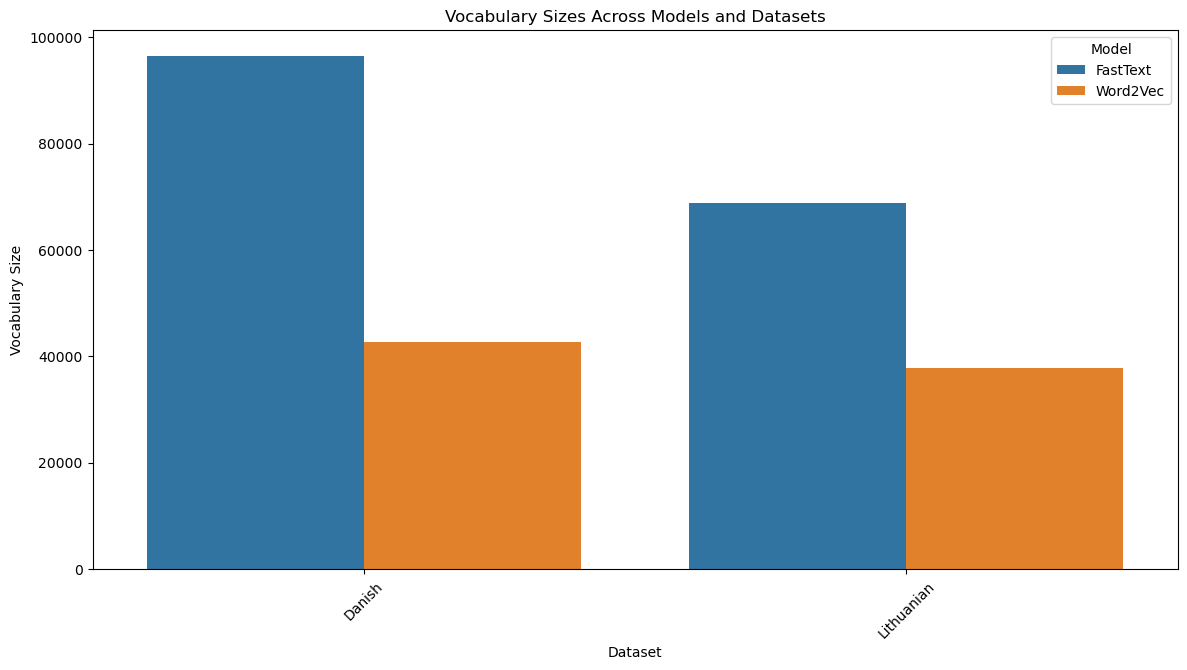

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(14, 7))
sns.barplot(x="Dataset", y="Vocabulary Size", hue="Model", data=df_vocab_sizes)
plt.title('Vocabulary Sizes Across Models and Datasets')
plt.xticks(rotation=45)
plt.show()

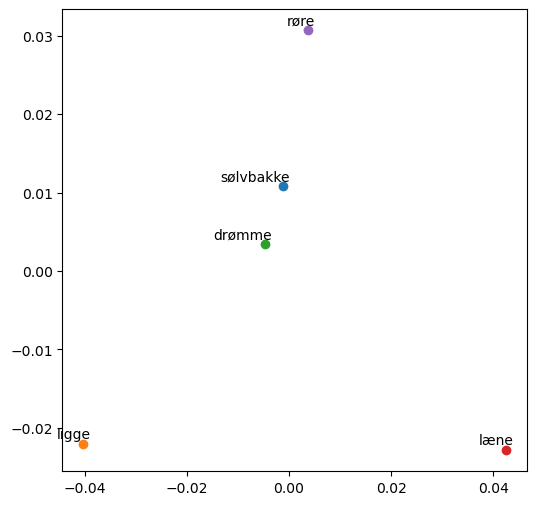

In [ ]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from gensim.models import FastText
import numpy as np
from sklearn.decomposition import PCA


words =  ['sølvbakke','ligge', 'drømme', 'læne', 'røre']
word_vectors = [fasttext_model_danish.wv[word] for word in words]


word_vectors_array = np.array(word_vectors)
pca = PCA(n_components=2)

vectors_2d = pca.fit_transform(word_vectors_array)

# Plotting
plt.figure(figsize=(6, 6))
for i, label in enumerate(words):
    x, y = vectors_2d[i]
    plt.scatter(x, y)
    plt.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points', ha='right', va='bottom')
plt.show()

In [ ]:
from nltk import ngrams
import numpy as np

def ngram_to_vector(ngram, model):
    """ Concatenate word vectors for each word in the n-gram. """
    vector_dim = model.vector_size
    ngram_vector = np.concatenate([model.wv[word] if word in model.wv else np.zeros(vector_dim) for word in ngram])
    return ngram_vector

def create_ngrams(text_tokens, model, n=3):
    """ Create a dataset of n-gram vectors, store only unique n-grams. """
    unique_ngrams_vectors = []
    seen_ngrams = set()  # To track unique n-grams

    for ngram in ngrams(text_tokens, n):
        ngram_tuple = tuple(ngram)  # Convert list to tuple for hashability
        if ngram_tuple not in seen_ngrams:
            seen_ngrams.add(ngram_tuple)
            vector = ngram_to_vector(ngram, model)
            unique_ngrams_vectors.append(vector) 

    return np.array(unique_ngrams_vectors)

In [ ]:
import glob
import tqdm

In [ ]:
def create_ngrams_dataset(input_folder, model):
    ngrams_dataset = []
    files = sorted(glob.glob(input_folder + '/*'))
    for file in tqdm.tqdm(files):
        text = ''
        with open(file) as f:
          text = f.read()
        tokens = text.split()
        ngrams = create_ngrams(tokens, model)
        ngrams_dataset.append(ngrams)
    return ngrams_dataset

In [ ]:
ngrams_fasttext_danish_bot = create_ngrams_dataset('preprocessed_danish_bot', fasttext_model_danish)
ngrams_fasttext_danish_human = create_ngrams_dataset('preprocessed_danish_human', fasttext_model_danish)
ngrams_word2vec_danish_bot = create_ngrams_dataset('preprocessed_danish_bot', word2vec_model_danish)
ngrams_word2vec_danish_human = create_ngrams_dataset('preprocessed_danish_human', word2vec_model_danish)

ngrams_fasttext_lithuanian_bot = create_ngrams_dataset('preprocessed_lithuanian_bot', fasttext_model_lithuanian)
ngrams_fasttext_lithuanian_human = create_ngrams_dataset('preprocessed_lithuanian_human', fasttext_model_lithuanian)
ngrams_word2vec_lithuanian_bot = create_ngrams_dataset('preprocessed_lithuanian_bot', word2vec_model_lithuanian)
ngrams_word2vec_lithuanian_human = create_ngrams_dataset('preprocessed_lithuanian_human', word2vec_model_lithuanian)

100%|██████████| 29/29 [00:06<00:00,  4.79it/s]


In [ ]:
print(len(ngrams_fasttext_danish_bot))
print(len(ngrams_fasttext_danish_bot[0]))
print(len(ngrams_fasttext_danish_bot[0][0]))

print()

print(len(ngrams_fasttext_danish_bot))
print(len(ngrams_fasttext_danish_bot[1]))
print(len(ngrams_fasttext_danish_bot[1][1]))

11
14756
30

11
7621
30


## Visualizations

In [ ]:
from sklearn.decomposition import PCA
import numpy as np

def reduce_dimension_with_pca(list_of_lists, n):
    
    # Собираем все векторы в один массив для обучения PCA
    all_vectors = np.vstack([np.array(sublist) for sublist in list_of_lists])
    
    # Если текущая размерность <= n, возвращаем исходные данные
    if all_vectors.shape[1] <= n:
        return list_of_lists
    
    # Обучаем PCA на всех векторах
    pca = PCA(n_components=n)
    pca.fit(all_vectors)  # Только обучение (без преобразования)
    
    # Применяем PCA к каждому подсписку, сохраняя структуру
    result = []
    for sublist in list_of_lists:
        transformed_vectors = pca.transform(np.array(sublist))
        if n == 1:
            # Преобразуем в плоский список скаляров
            result.append([x[0] for x in transformed_vectors.tolist()])
        else:
            # Оставляем как список векторов
            result.append(transformed_vectors.tolist())
    
    return result

In [ ]:
ngrams_fasttext_danish_bot_2d_pca = reduce_dimension_with_pca(ngrams_fasttext_danish_bot, 2)
ngrams_fasttext_danish_human_2d_pca = reduce_dimension_with_pca(ngrams_fasttext_danish_human, 2)
ngrams_word2vec_danish_bot_2d_pca = reduce_dimension_with_pca(ngrams_word2vec_danish_bot, 2)
ngrams_word2vec_danish_human_2d_pca = reduce_dimension_with_pca(ngrams_word2vec_danish_human, 2)

ngrams_fasttext_lithuanian_bot_2d_pca = reduce_dimension_with_pca(ngrams_fasttext_lithuanian_bot, 2)
ngrams_fasttext_lithuanian_human_2d_pca = reduce_dimension_with_pca(ngrams_fasttext_lithuanian_human, 2)
ngrams_word2vec_lithuanian_bot_2d_pca = reduce_dimension_with_pca(ngrams_word2vec_lithuanian_bot, 2)
ngrams_word2vec_lithuanian_human_2d_pca = reduce_dimension_with_pca(ngrams_word2vec_lithuanian_human, 2)

In [ ]:
import matplotlib.pyplot as plt

def visualize_vectors(word2vec_bot, word2vec_human, fasttext_bot, fasttext_human, title):
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    fig.suptitle(title, fontsize=16)
    
    # Word2Vec Bot
    if word2vec_bot:
        all_vectors = [vec for text in word2vec_bot for vec in text]
        if all_vectors:
            x, y = zip(*all_vectors)
            axes[0, 0].scatter(x, y, color='blue', alpha=0.5, s=20)
            axes[0, 0].set_title('Word2Vec Bot')
            axes[0, 0].grid(True)
    
    # Word2Vec Human
    if word2vec_human:
        all_vectors = [vec for text in word2vec_human for vec in text]
        if all_vectors:
            x, y = zip(*all_vectors)
            axes[0, 1].scatter(x, y, color='red', alpha=0.5, s=20)
            axes[0, 1].set_title('Word2Vec Human')
            axes[0, 1].grid(True)
    
    # FastText Bot
    if fasttext_bot:
        all_vectors = [vec for text in fasttext_bot for vec in text]
        if all_vectors:
            x, y = zip(*all_vectors)
            axes[1, 0].scatter(x, y, color='green', alpha=0.5, s=20)
            axes[1, 0].set_title('FastText Bot')
            axes[1, 0].grid(True)
    
    # FastText Human
    if fasttext_human:
        all_vectors = [vec for text in fasttext_human for vec in text]
        if all_vectors:
            x, y = zip(*all_vectors)
            axes[1, 1].scatter(x, y, color='purple', alpha=0.5, s=20)
            axes[1, 1].set_title('FastText Human')
            axes[1, 1].grid(True)
    
    plt.tight_layout()
    plt.show()

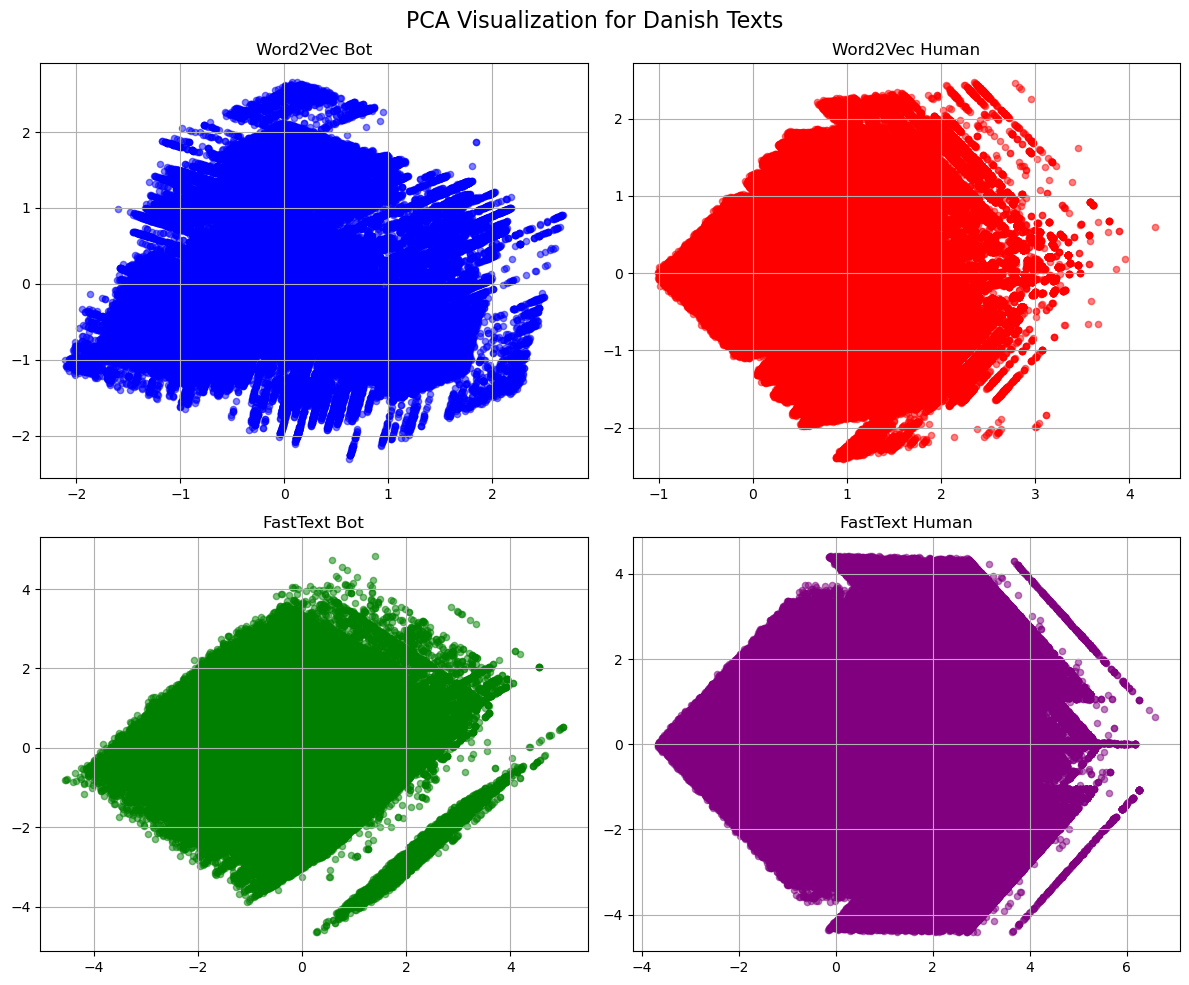

In [ ]:
visualize_vectors(ngrams_word2vec_danish_bot_2d_pca, ngrams_word2vec_danish_human_2d_pca, ngrams_fasttext_danish_bot_2d_pca, ngrams_fasttext_danish_human_2d_pca, 'PCA Visualization for Danish Texts')

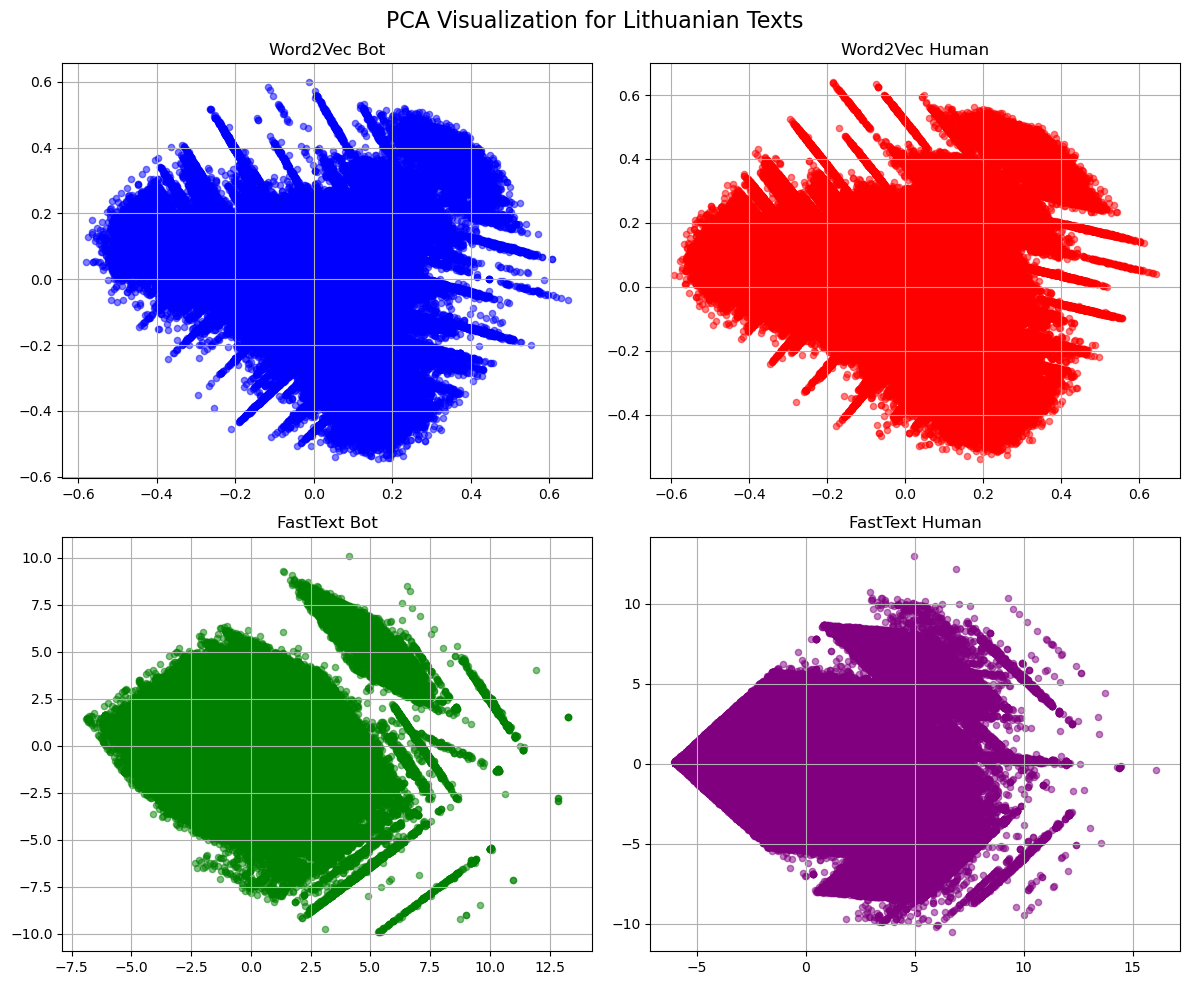

In [ ]:
visualize_vectors(ngrams_word2vec_lithuanian_bot_2d_pca, ngrams_word2vec_lithuanian_human_2d_pca, ngrams_fasttext_lithuanian_bot_2d_pca, ngrams_fasttext_lithuanian_human_2d_pca, 'PCA Visualization for Lithuanian Texts')

In [ ]:
from sklearn.manifold import TSNE
import numpy as np

def reduce_dimension_with_tsne(list_of_lists, n, perplexity=10.0, random_state=42, pca_components=10):

    # Собираем все векторы в один массив для обучения t-SNE
    all_vectors = np.vstack([np.array(sublist) for sublist in list_of_lists])
    
    # Если текущая размерность <= n, возвращаем исходные данные
    if all_vectors.shape[1] <= n:
        return list_of_lists
    
    # Сначала уменьшаем размерность с помощью PCA до pca_components
    if all_vectors.shape[1] > pca_components:
        pca = PCA(n_components=pca_components, random_state=random_state)
        all_vectors = pca.fit_transform(all_vectors)

    # Обучаем t-SNE на всех векторах
    tsne = TSNE(
        n_components=n,
        perplexity=perplexity,
        random_state=random_state,
        init='pca',  # Используем PCA для инициализации (улучшает стабильность)
        n_iter=250,
        n_iter_without_progress=50,  # Ранняя остановка
        verbose=1
    )
    transformed_all = tsne.fit_transform(all_vectors)  # Обучение + преобразование
    
    # Восстанавливаем исходную структуру списков
    result = []
    idx = 0
    for sublist in list_of_lists:
        sublist_len = len(sublist)
        transformed_sublist = transformed_all[idx : idx + sublist_len]
        result.append(transformed_sublist.tolist())
        idx += sublist_len
    
    return result

In [ ]:
ngrams_fasttext_danish_bot_2d_tsne = reduce_dimension_with_tsne(ngrams_fasttext_danish_bot, 2)
ngrams_fasttext_danish_human_2d_tsne = reduce_dimension_with_tsne(ngrams_fasttext_danish_human, 2)
ngrams_word2vec_danish_bot_2d_tsne = reduce_dimension_with_tsne(ngrams_word2vec_danish_bot, 2)
ngrams_word2vec_danish_human_2d_tsne = reduce_dimension_with_tsne(ngrams_word2vec_danish_human, 2)

In [ ]:
visualize_vectors(ngrams_word2vec_danish_bot_2d_tsne, ngrams_word2vec_danish_human_2d_tsne, ngrams_fasttext_danish_bot_2d_tsne, ngrams_fasttext_danish_human_2d_tsne)

In [ ]:
import ordpy
import tqdm

def calculate_entropy_complexity(ngrams_1d):
    result = []
    for x in tqdm.tqdm(ngrams_1d):
        Hs = ordpy.permutation_entropy(x, dx=3)  
        Cjs = ordpy.complexity_entropy(x, dx=3)[1]
        result.append([Hs, Cjs])
    return result

In [ ]:
ngrams_fasttext_danish_bot_1d_pca = reduce_dimension_with_pca(ngrams_fasttext_danish_bot, 1)
ngrams_fasttext_danish_human_1d_pca = reduce_dimension_with_pca(ngrams_fasttext_danish_human, 1)
ngrams_word2vec_danish_bot_1d_pca = reduce_dimension_with_pca(ngrams_word2vec_danish_bot, 1)
ngrams_word2vec_danish_human_1d_pca = reduce_dimension_with_pca(ngrams_word2vec_danish_human, 1)

ngrams_fasttext_lithuanian_bot_1d_pca = reduce_dimension_with_pca(ngrams_fasttext_lithuanian_bot, 1)
ngrams_fasttext_lithuanian_human_1d_pca = reduce_dimension_with_pca(ngrams_fasttext_lithuanian_human, 1)
ngrams_word2vec_lithuanian_bot_1d_pca = reduce_dimension_with_pca(ngrams_word2vec_lithuanian_bot, 1)
ngrams_word2vec_lithuanian_human_1d_pca = reduce_dimension_with_pca(ngrams_word2vec_lithuanian_human, 1)

In [ ]:
len(ngrams_fasttext_danish_bot_1d_pca[0])

14756

In [ ]:
len(ngrams_fasttext_danish_bot_1d_pca)

11

In [ ]:
entropy_complexity_fasttext_danish_bot_pca = calculate_entropy_complexity(ngrams_fasttext_danish_bot_1d_pca)
entropy_complexity_fasttext_danish_human_pca = calculate_entropy_complexity(ngrams_fasttext_danish_human_1d_pca)
entropy_complexity_word2vec_danish_bot_pca = calculate_entropy_complexity(ngrams_word2vec_danish_bot_1d_pca)
entropy_complexity_word2vec_danish_human_pca = calculate_entropy_complexity(ngrams_word2vec_danish_human_1d_pca)

entropy_complexity_fasttext_lithuanian_bot_pca = calculate_entropy_complexity(ngrams_fasttext_lithuanian_bot_1d_pca)
entropy_complexity_fasttext_lithuanian_human_pca = calculate_entropy_complexity(ngrams_fasttext_lithuanian_human_1d_pca)
entropy_complexity_word2vec_lithuanian_bot_pca = calculate_entropy_complexity(ngrams_word2vec_lithuanian_bot_1d_pca)
entropy_complexity_word2vec_lithuanian_human_pca = calculate_entropy_complexity(ngrams_word2vec_lithuanian_human_1d_pca)

100%|██████████| 29/29 [00:05<00:00,  4.94it/s]


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_entropy_complexity(word2vec_bot, word2vec_human, fasttext_bot, fasttext_human, title, max_entropy=None):
    # Объединяем все данные для определения границ
    all_data = word2vec_bot + word2vec_human + fasttext_bot + fasttext_human
    all_entropies = [x[0] for x in all_data]
    
    # Если max_entropy не задан, вычисляем из данных с небольшим запасом
    if max_entropy is None:
        max_entropy = max(all_entropies) * 1.02
    
    # Создаем кривую границы
    h = np.linspace(0, max_entropy, 100)
    c_upper = h * (1 - h/max_entropy)  # Верхняя граница сложности
    
    # Создаем фигуру с двумя подграфиками
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

    # График для word2vec
    w2v_bot_entropy = [x[0] for x in word2vec_bot]
    w2v_bot_complexity = [x[1] for x in word2vec_bot]
    w2v_human_entropy = [x[0] for x in word2vec_human]
    w2v_human_complexity = [x[1] for x in word2vec_human]

    ax1.plot(h, c_upper, 'k--', alpha=0.5, label='Theoretical boundary')
    ax1.fill_between(h, 0, c_upper, color='gray', alpha=0.1)
    ax1.scatter(w2v_bot_entropy, w2v_bot_complexity, color='blue', label='Bot', alpha=0.6)
    ax1.scatter(w2v_human_entropy, w2v_human_complexity, color='red', label='Human', alpha=0.6)
    ax1.set_title('Word2Vec Entropy-Complexity Plane')
    ax1.set_xlabel('Entropy')
    ax1.set_ylabel('Complexity')
    ax1.legend()
    ax1.grid(True, linestyle='--', alpha=0.6)
    ax1.set_xlim(0, max_entropy)
    ax1.set_ylim(0, max(c_upper)*1.1)

    # График для fasttext
    ft_bot_entropy = [x[0] for x in fasttext_bot]
    ft_bot_complexity = [x[1] for x in fasttext_bot]
    ft_human_entropy = [x[0] for x in fasttext_human]
    ft_human_complexity = [x[1] for x in fasttext_human]

    ax2.plot(h, c_upper, 'k--', alpha=0.5, label='Theoretical boundary')
    ax2.fill_between(h, 0, c_upper, color='gray', alpha=0.1)
    ax2.scatter(ft_bot_entropy, ft_bot_complexity, color='blue', label='Bot', alpha=0.6)
    ax2.scatter(ft_human_entropy, ft_human_complexity, color='red', label='Human', alpha=0.6)
    ax2.set_title('FastText Entropy-Complexity Plane')
    ax2.set_xlabel('Entropy')
    ax2.set_ylabel('Complexity')
    ax2.legend()
    ax2.grid(True, linestyle='--', alpha=0.6)
    ax2.set_xlim(0, max_entropy)
    ax2.set_ylim(0, max(c_upper)*1.1)

    plt.suptitle(title, y=1.02, fontsize=14)
    plt.tight_layout()
    plt.show()

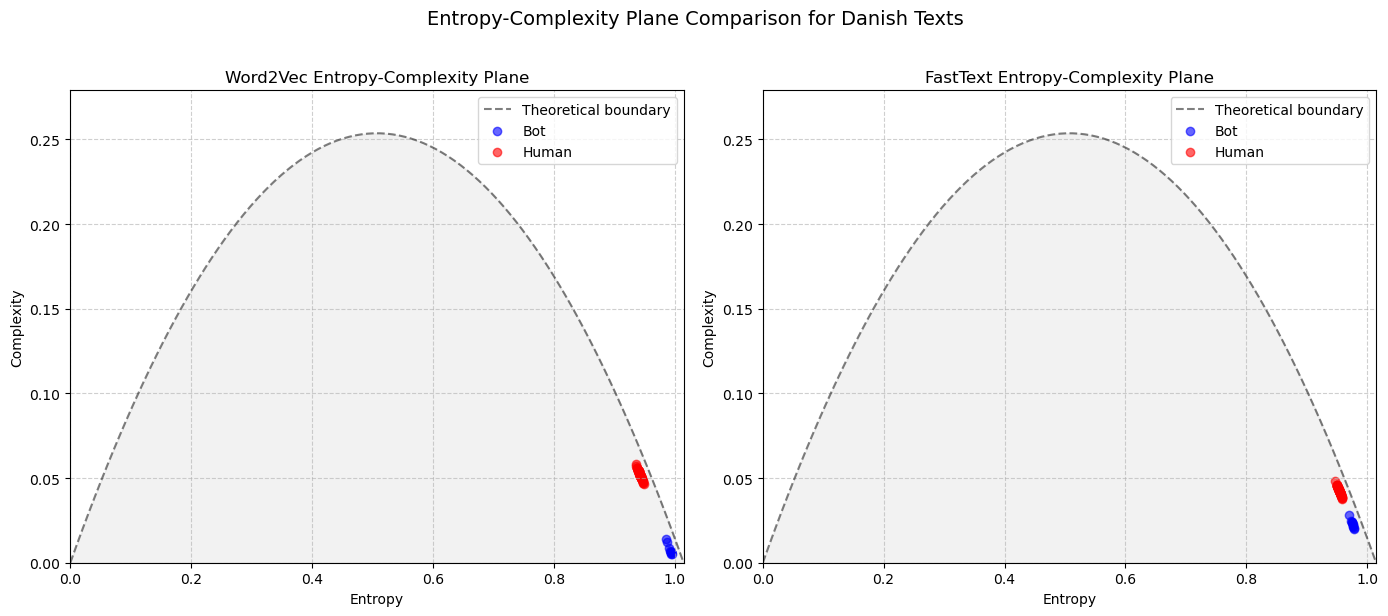

In [ ]:
plot_entropy_complexity(entropy_complexity_word2vec_danish_bot_pca, entropy_complexity_word2vec_danish_human_pca, entropy_complexity_fasttext_danish_bot_pca, entropy_complexity_fasttext_danish_human_pca, 'Entropy-Complexity Plane Comparison for Danish Texts')

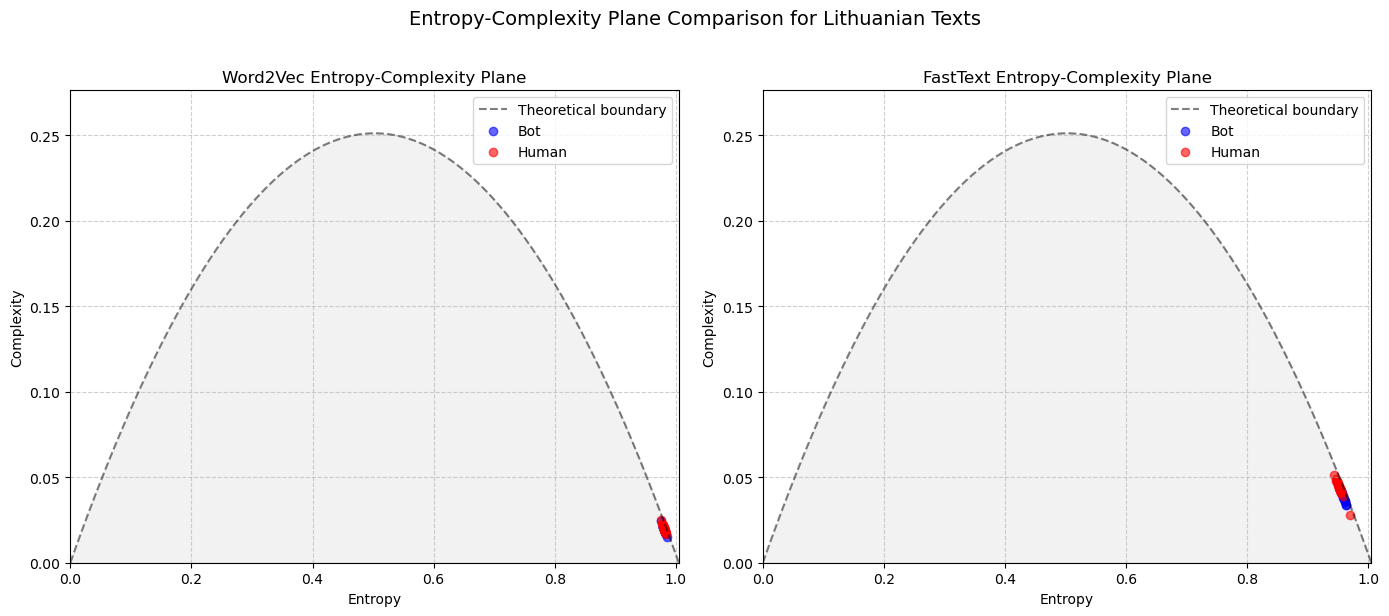

In [ ]:
plot_entropy_complexity(entropy_complexity_word2vec_lithuanian_bot_pca, entropy_complexity_word2vec_lithuanian_human_pca, entropy_complexity_fasttext_lithuanian_bot_pca, entropy_complexity_fasttext_lithuanian_human_pca, 'Entropy-Complexity Plane Comparison for Lithuanian Texts')

## SVD

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
def make_matrix_W_list_of_words(corpus_path, min_df, max_df=None, token_pattern = None, use_idf = True):
  '''
  corpus_path - is a path to the corpus, where one line - one text

  min_df - is the minimum times (or fraction of the texts) a word must occur in the corpus

  max_df - is the maximum times (or fraction of the texts) a word must occur in the corpus
  if it is None, there are no upper bound

  token_pattern - alphabet, which will be considered. Usually can be all letters of the language and numbers
  if None all symbols will be OK

  use_idf - is bool value whether to use idf
  '''
  with open(corpus_path, 'r') as corpus_file:
        if token_pattern:
            vectorizer = TfidfVectorizer(analyzer='word', min_df=min_df, token_pattern=token_pattern, use_idf=use_idf)
        else:
            vectorizer = TfidfVectorizer(analyzer='word', min_df=min_df, use_idf=use_idf)
        data_vectorized = vectorizer.fit_transform(corpus_file)
  return data_vectorized, vectorizer.get_feature_names_out()

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
def make_matrix_W_list_of_words(corpus_path, min_df, max_df=None, token_pattern = None, use_idf = True):
  with open(corpus_path, 'r') as corpus_file:
        if token_pattern:
            vectorizer = TfidfVectorizer(analyzer='word', min_df=min_df, token_pattern=token_pattern, use_idf=use_idf)
        else:
            vectorizer = TfidfVectorizer(analyzer='word', min_df=min_df, use_idf=use_idf)
        data_vectorized = vectorizer.fit_transform(corpus_file)
  return data_vectorized, vectorizer.get_feature_names_out()

In [ ]:
W_danish, words_list_danish  = make_matrix_W_list_of_words('corpus_danish.txt', 1)
W_lithuanian, words_list_lithuanian  = make_matrix_W_list_of_words('corpus_danish.txt', 1)

In [ ]:
len(words_list_danish)

87893

In [ ]:
from scipy.sparse.linalg import svds
import numpy as np

In [ ]:
def apply_svd(W, k):
  u, sigma, vt = svds(W, k)
  descending_order_of_inds = np.flip(np.argsort(sigma))
  u = u[:,descending_order_of_inds]
  vt = vt[descending_order_of_inds]
  sigma = sigma[descending_order_of_inds]
  assert sigma.shape == (k,)
  assert vt.shape == (k, W.shape[1])
  assert u.shape == (W.shape[0], k)

  return np.dot(np.diag(sigma), vt).T

In [ ]:
def create_dictionary(words_list, vv, output_file):
  dictionary = {}
  for word, vector in zip(words_list, vv):
    dictionary[word] = vector
  np.save(output_file, dictionary)
  return dictionary

In [ ]:
svd_dictionary_danish = create_dictionary(words_list_danish, apply_svd(W_danish, 1), 'svd_dictionary_danish.npy')
svd_dictionary_lithuanian = create_dictionary(words_list_danish, apply_svd(W_lithuanian, 1), 'svd_dictionary_lithuanian.npy')

In [ ]:
svd_dictionary_danish = np.load('svd_dictionary_danish.npy', allow_pickle=True)[()]
svd_dictionary_lithuanian = np.load('svd_dictionary_lithuanian.npy', allow_pickle=True)[()]

In [ ]:
svd_dictionary_danish['besættelsestro']

array([-0.00028059])

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tqdm
import glob
import os

def plot_trajectories_grid(folder_path, word_dict, title, plots_per_row=3, max_points=300, figsize=(20, 4)):
    
    def visualize_trajectory(input_path, wdict, ax, m=0, max_points=1000):
        """Вспомогательная функция для отрисовки одного графика"""
        with open(input_path, 'r') as f:
            text = f.read()
        words = [w for w in text.split() if w in wdict]
        ts = np.array([wdict[w][-m:][::-1] for w in words])
        
        ax.plot(ts[:max_points, 0])
        # ax.set_title(os.path.basename(input_path))
        ax.grid(True)

    # Получаем список файлов
    files = sorted(glob.glob(os.path.join(folder_path, '*')))
    if not files:
        print(f"В папке {folder_path} не найдено файлов")
        return

    # Создаем сетку графиков
    n_files = len(files)
    n_rows = (n_files + plots_per_row - 1) // plots_per_row
    
    # Вычисляем общий размер фигуры
    row_height = figsize[1]
    total_figsize = (figsize[0], row_height * n_rows)
    
    fig, axes = plt.subplots(n_rows, plots_per_row, figsize=total_figsize)
    fig.suptitle(title, fontsize=16, y=1.02)
    fig.tight_layout(pad=3.0, h_pad=4.0, w_pad=2.0)
    
    # Если только один subplot, преобразуем axes в массив для единообразия
    if n_rows == 1 and plots_per_row == 1:
        axes = np.array([axes])
    elif n_rows == 1 or plots_per_row == 1:
        axes = axes.reshape(-1)

    # Рисуем графики
    for i, file in enumerate(tqdm.tqdm(files, desc="Обработка файлов")):
        row = i // plots_per_row
        col = i % plots_per_row
        
        if n_rows > 1 and plots_per_row > 1:
            ax = axes[row, col]
        else:
            ax = axes[i]
        
        visualize_trajectory(file, word_dict, ax=ax, max_points=max_points)

    # Скрываем пустые subplots
    for j in range(i + 1, n_rows * plots_per_row):
        row = j // plots_per_row
        col = j % plots_per_row
        
        if n_rows > 1 and plots_per_row > 1:
            axes[row, col].axis('off')
        else:
            if j < len(axes):
                axes[j].axis('off')

    plt.show()

Обработка файлов: 100%|██████████| 11/11 [00:00<00:00, 71.36it/s]


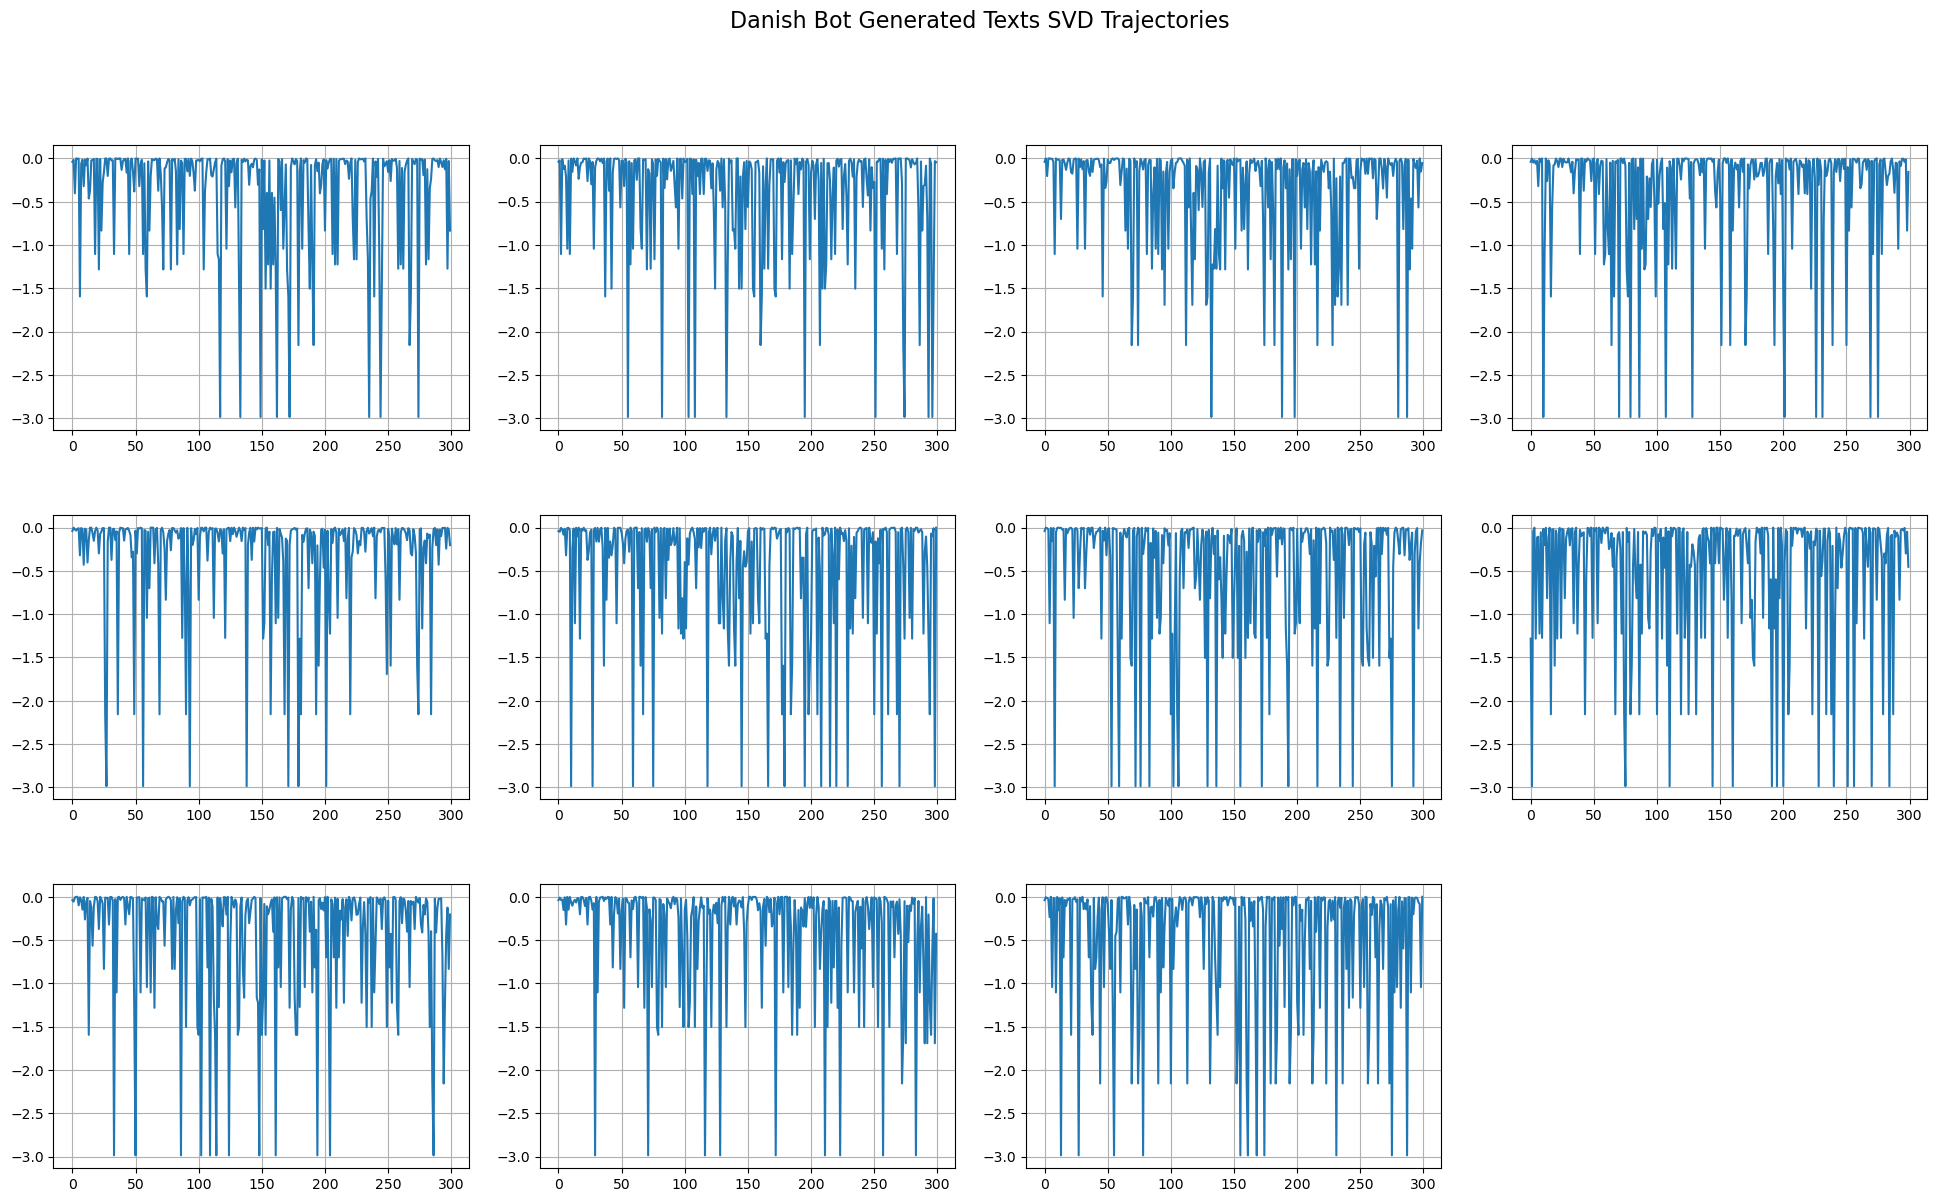

In [ ]:
plot_trajectories_grid('preprocessed_danish_bot', svd_dictionary_danish, 'Danish Bot Generated Texts SVD Trajectories', plots_per_row=4)

Обработка файлов: 100%|██████████| 56/56 [00:02<00:00, 26.79it/s]


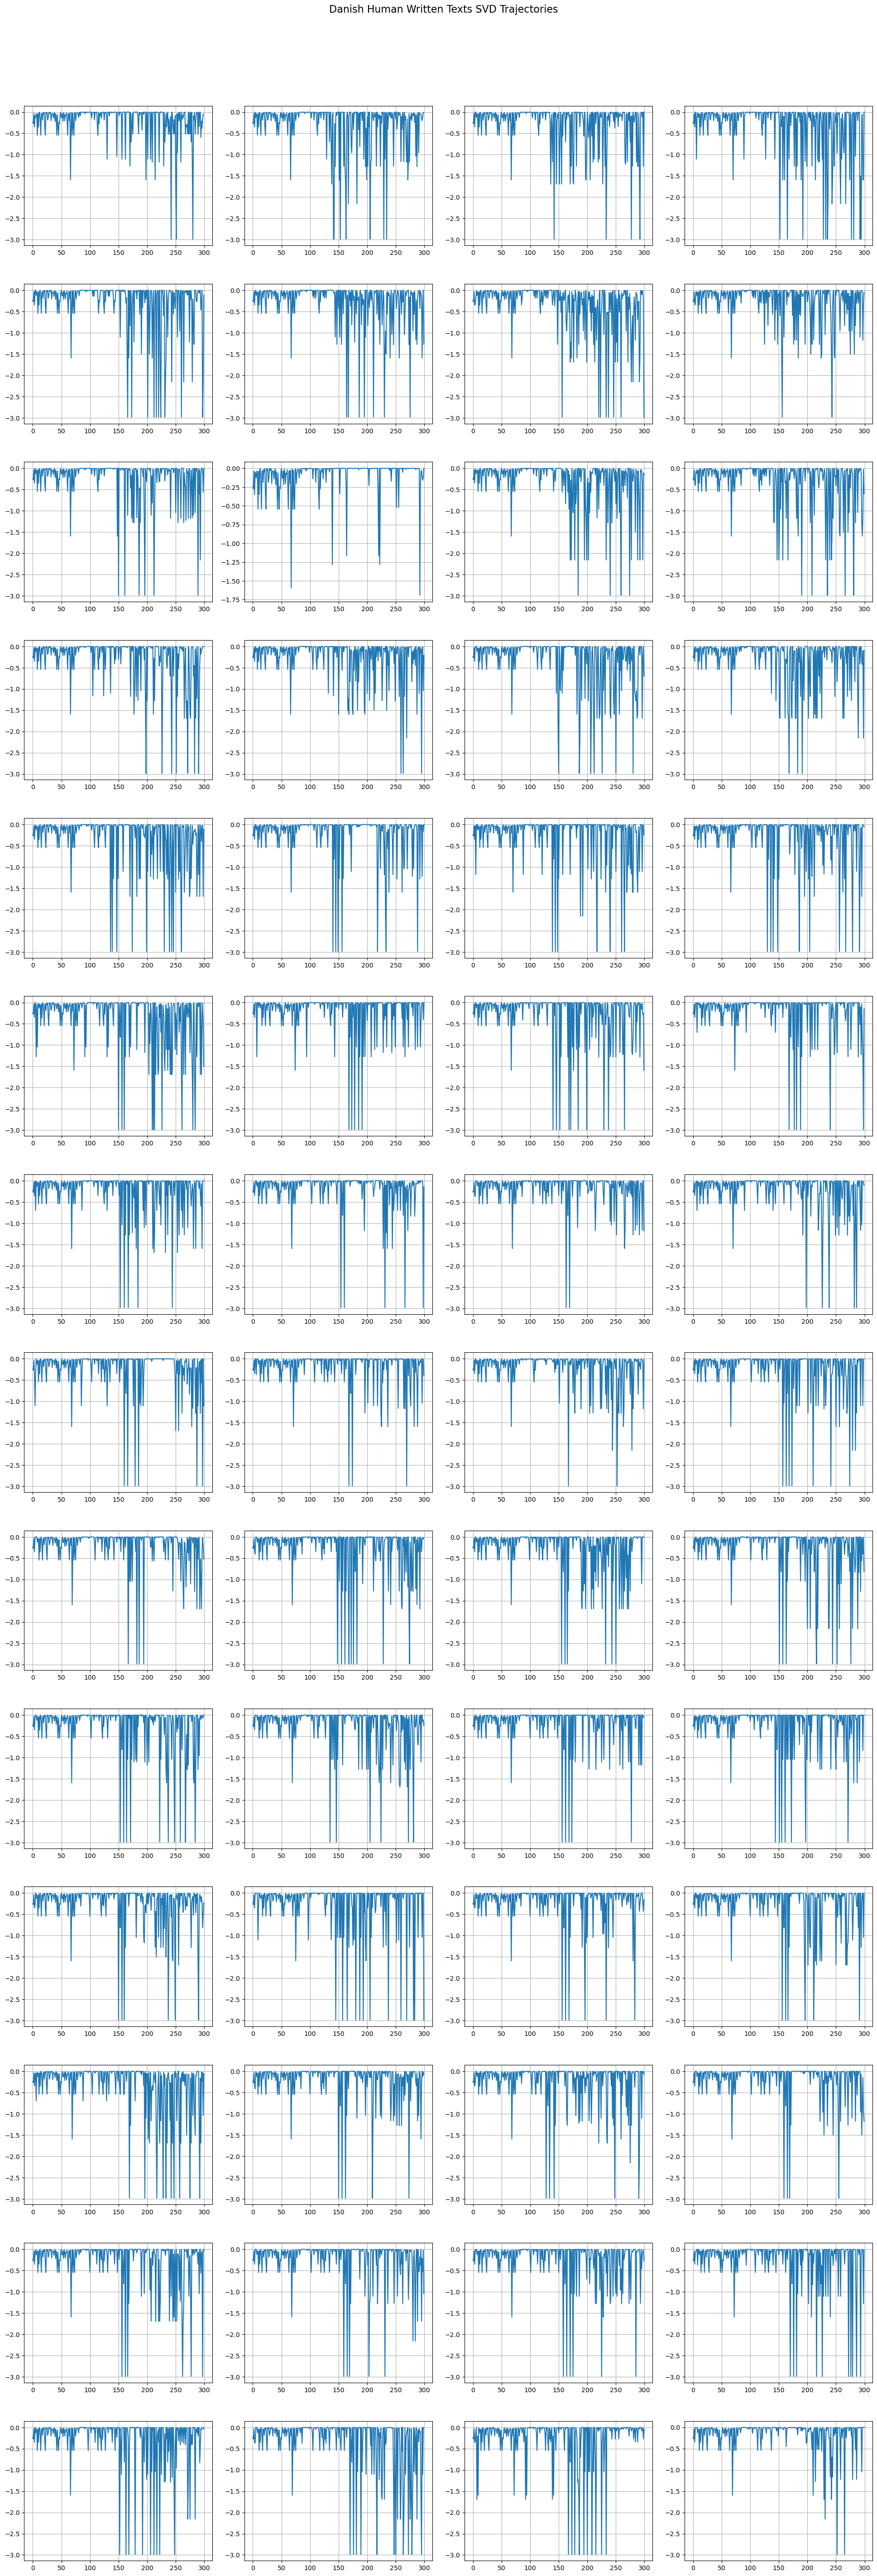

In [ ]:
plot_trajectories_grid('preprocessed_danish_human', svd_dictionary_danish, 'Danish Human Written Texts SVD Trajectories', plots_per_row=4)

Обработка файлов: 100%|██████████| 15/15 [00:00<00:00, 230.34it/s]


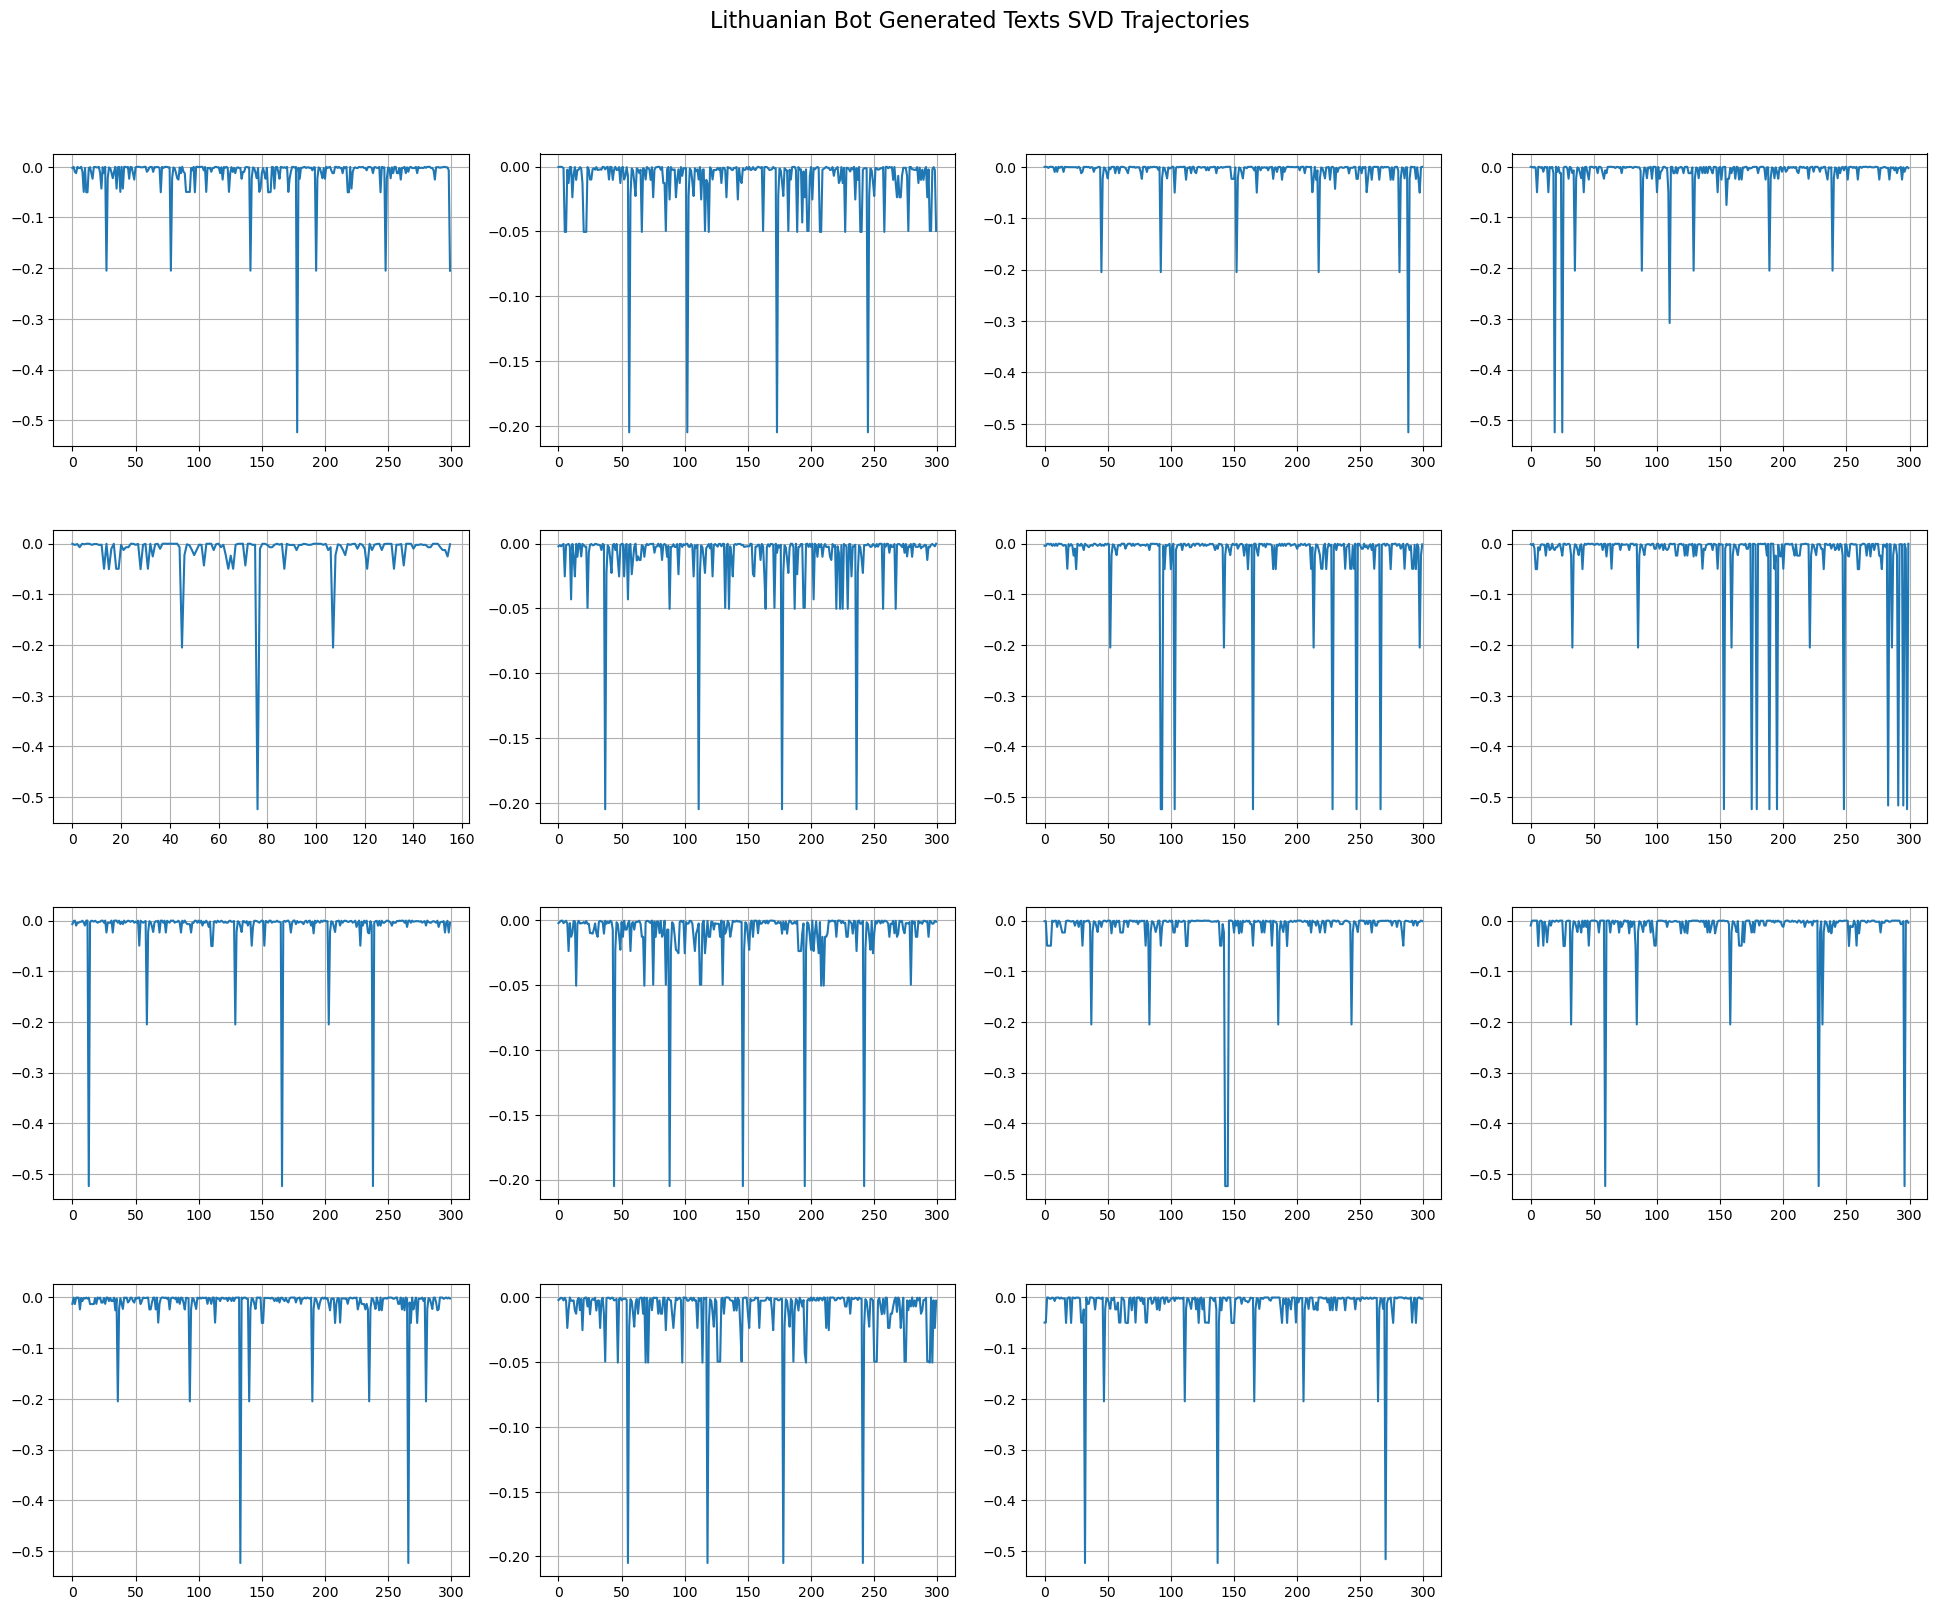

In [ ]:
plot_trajectories_grid('preprocessed_lithuanian_bot', svd_dictionary_danish, 'Lithuanian Bot Generated Texts SVD Trajectories', plots_per_row=4)

Обработка файлов: 100%|██████████| 29/29 [00:00<00:00, 92.64it/s]


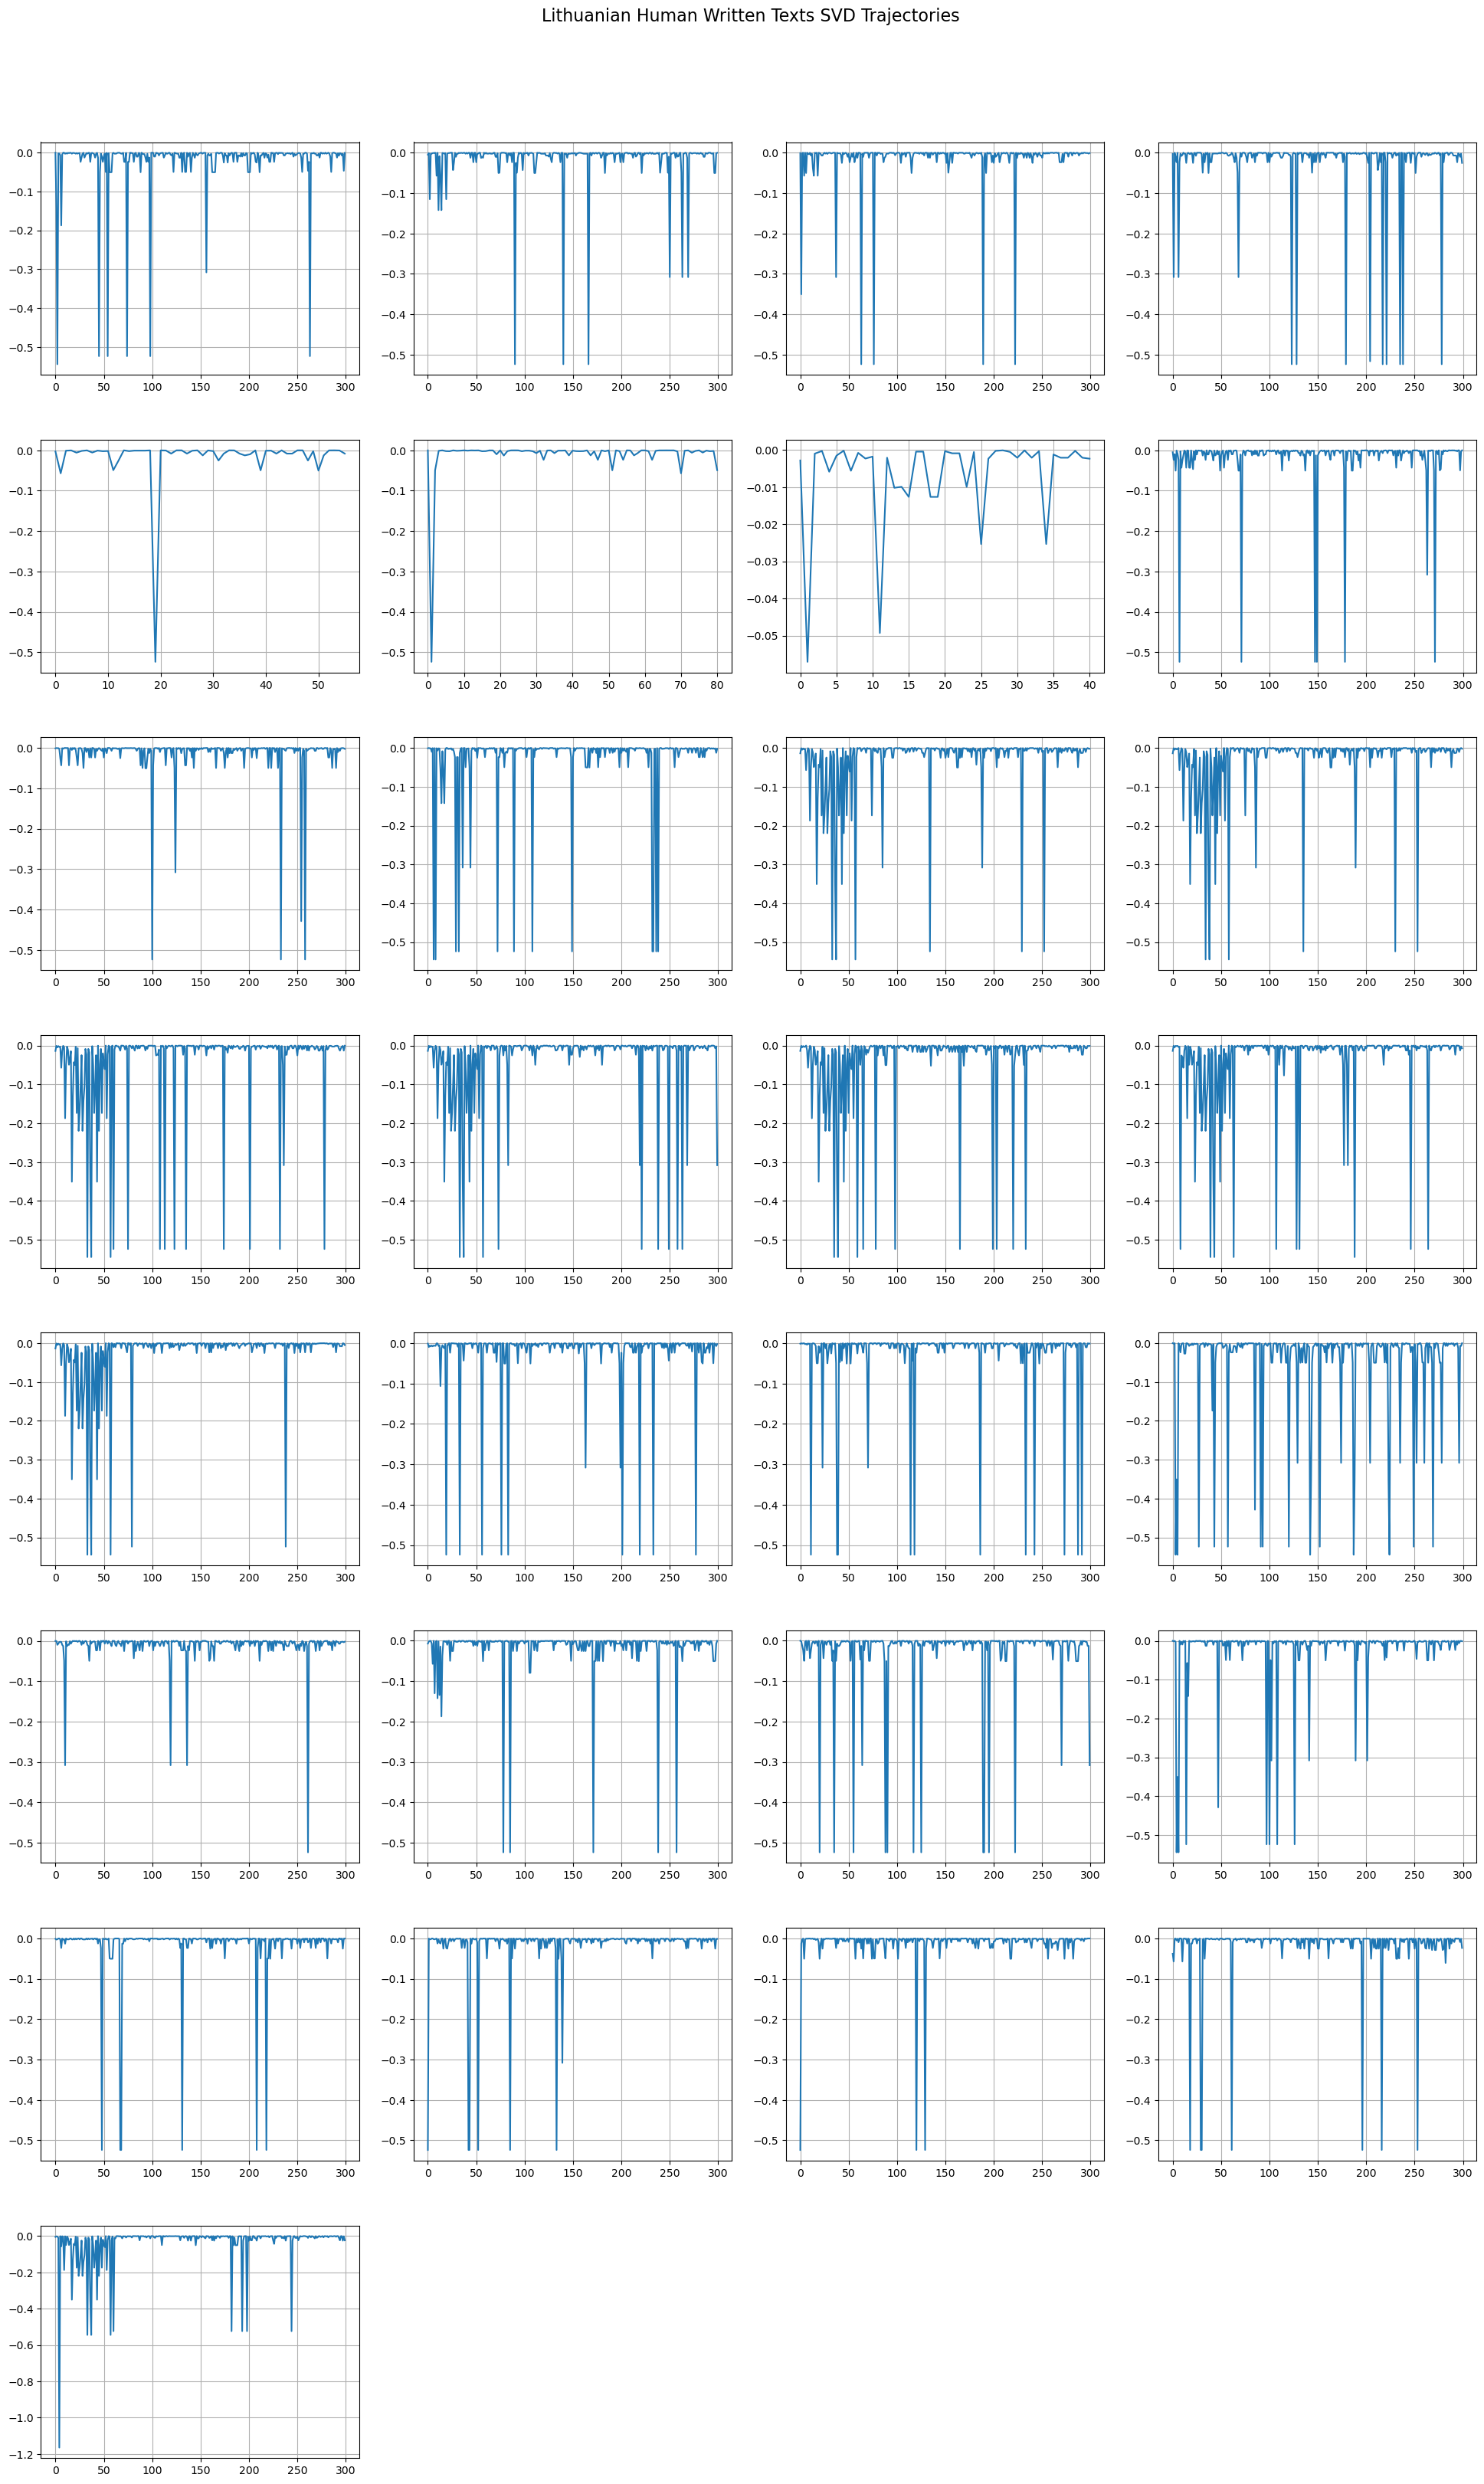

In [ ]:
plot_trajectories_grid('preprocessed_lithuanian_human', svd_dictionary_danish, 'Lithuanian Human Written Texts SVD Trajectories', plots_per_row=4)

In [ ]:
def get_trajectory(input_path, wdict, m=0):
        with open(input_path, 'r') as f:
            text = f.read()
        words = [w for w in text.split() if w in wdict]
        ts = np.array([wdict[w][-m:][::-1][0] for w in words])
        return np.array(ts)

In [ ]:
get_trajectory('preprocessed_danish_bot/PREPROCESSED_Aske og Afdøen.txt', svd_dictionary_danish)

array([-0.03955384, -0.01729928, -0.40347534, ..., -0.02463749,
       -1.16533116, -0.01940981])

In [ ]:
import ordpy
import tqdm

def calculate_svd_entropy_complexity(folder, svd_dictionary):
    result = []
    files = sorted(glob.glob(folder + '/*'))
    for file in tqdm.tqdm(files):
        traj = get_trajectory(file, svd_dictionary)
        # print(traj)
        Hs = ordpy.permutation_entropy(traj, dx=3)  
        Cjs = ordpy.complexity_entropy(traj, dx=3)[1]
        result.append([Hs, Cjs])
        
    return result

In [ ]:
svd_entropy_comlexity_danish_bot = calculate_svd_entropy_complexity('preprocessed_danish_bot', svd_dictionary_danish)
svd_entropy_comlexity_danish_human = calculate_svd_entropy_complexity('preprocessed_danish_human', svd_dictionary_danish)

svd_entropy_comlexity_lithuanian_bot = calculate_svd_entropy_complexity('preprocessed_lithuanian_bot', svd_dictionary_lithuanian)
svd_entropy_comlexity_lithuanian_human = calculate_svd_entropy_complexity('preprocessed_lithuanian_human', svd_dictionary_lithuanian)

100%|██████████| 29/29 [00:00<00:00, 37.07it/s]


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_entropy_complexity(svd_danish_bot, svd_danish_human, svd_lithuanian_bot, svd_lithuanian_human, title, max_entropy=None):
    # Объединяем все данные для определения границ
    all_data = svd_danish_bot + svd_danish_human + svd_lithuanian_bot + svd_lithuanian_human
    all_entropies = [x[0] for x in all_data]
    
    # Если max_entropy не задан, вычисляем из данных с небольшим запасом
    if max_entropy is None:
        max_entropy = max(all_entropies) * 1.02
    
    # Создаем кривую границы
    h = np.linspace(0, max_entropy, 100)
    c_upper = h * (1 - h/max_entropy)  # Верхняя граница сложности
    
    # Создаем фигуру с двумя подграфиками
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

    # График для word2vec
    svd_danish_bot_entropy = [x[0] for x in svd_danish_bot]
    svd_danish_bot_complexity = [x[1] for x in svd_danish_bot]
    svd_danish_human_entropy = [x[0] for x in svd_danish_human]
    svd_danish_human_complexity = [x[1] for x in svd_danish_human]

    ax1.plot(h, c_upper, 'k--', alpha=0.5, label='Theoretical boundary')
    ax1.fill_between(h, 0, c_upper, color='gray', alpha=0.1)
    ax1.scatter(svd_danish_bot_entropy, svd_danish_bot_complexity, color='blue', label='Bot', alpha=0.6)
    ax1.scatter(svd_danish_human_entropy, svd_danish_human_complexity, color='red', label='Human', alpha=0.6)
    ax1.set_title('SVD Entropy-Complexity Plane for Danish Texts')
    ax1.set_xlabel('Entropy')
    ax1.set_ylabel('Complexity')
    ax1.legend()
    ax1.grid(True, linestyle='--', alpha=0.6)
    ax1.set_xlim(0, max_entropy)
    ax1.set_ylim(0, max(c_upper)*1.1)

    # График для fasttext
    svd_lithuanian_bot_entropy = [x[0] for x in svd_lithuanian_bot]
    svd_lithuanian_bot_complexity = [x[1] for x in svd_lithuanian_bot]
    svd_lithuanian_human_entropy = [x[0] for x in svd_lithuanian_human]
    svd_lithuanian_human_complexity = [x[1] for x in svd_lithuanian_human]

    ax2.plot(h, c_upper, 'k--', alpha=0.5, label='Theoretical boundary')
    ax2.fill_between(h, 0, c_upper, color='gray', alpha=0.1)
    ax2.scatter(svd_lithuanian_bot_entropy, svd_lithuanian_bot_complexity, color='blue', label='Bot', alpha=0.6)
    ax2.scatter(svd_lithuanian_human_entropy, svd_lithuanian_human_complexity, color='red', label='Human', alpha=0.6)
    ax2.set_title('SVD Entropy-Complexity Plane for Lithuanian Texts')
    ax2.set_xlabel('Entropy')
    ax2.set_ylabel('Complexity')
    ax2.legend()
    ax2.grid(True, linestyle='--', alpha=0.6)
    ax2.set_xlim(0, max_entropy)
    ax2.set_ylim(0, max(c_upper)*1.1)

    plt.suptitle(title, y=1.02, fontsize=14)
    plt.tight_layout()
    plt.show()

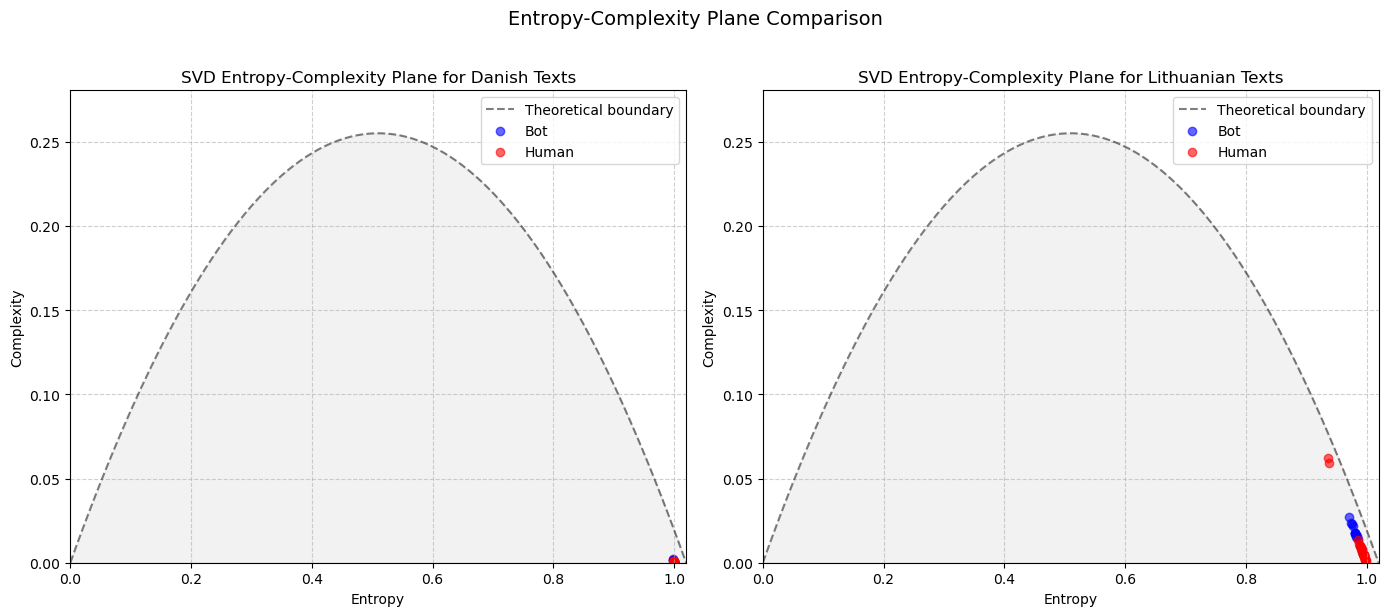

In [ ]:
plot_entropy_complexity(svd_entropy_comlexity_danish_bot, svd_entropy_comlexity_danish_human, svd_entropy_comlexity_lithuanian_bot, svd_entropy_comlexity_lithuanian_human, 'Entropy-Complexity Plane Comparison')

In [220]:
fasttext_model_danish = FastText.load("fasttext_danish.model")
word2vec_model_danish = Word2Vec.load("word2vec_danish.model")
fasttext_model_lithuanian = FastText.load("fasttext_lithuanian.model")
word2vec_model_lithuanian = Word2Vec.load("word2vec_lithuanian.model")

# Extract vocabulary sizes
vocab_sizes = {
    "Danish": {
        "FastText": len(fasttext_model_danish.wv.key_to_index),
        "Word2Vec": len(word2vec_model_danish.wv.key_to_index),
        "SVD": len(words_list_danish)
    },
    "Lithuanian": {
        "FastText": len(fasttext_model_lithuanian.wv.key_to_index),
        "Word2Vec": len(word2vec_model_lithuanian.wv.key_to_index),
        "SVD": len(words_list_lithuanian)
    }
}


import pandas as pd

# Flatten the dictionary into a list of dictionaries for DataFrame creation
data_for_df = []
for dataset, models in vocab_sizes.items():
    for model, size in models.items():
        data_for_df.append({"Dataset": dataset, "Model": model, "Vocabulary Size": size})


df_vocab_sizes = pd.DataFrame(data_for_df)

In [221]:
df_vocab_sizes

Dataset     Model  Vocabulary Size
0      Danish  FastText            96529
1      Danish  Word2Vec            42778
2      Danish       SVD            87893
3  Lithuanian  FastText            68875
4  Lithuanian  Word2Vec            37860
5  Lithuanian       SVD            87893

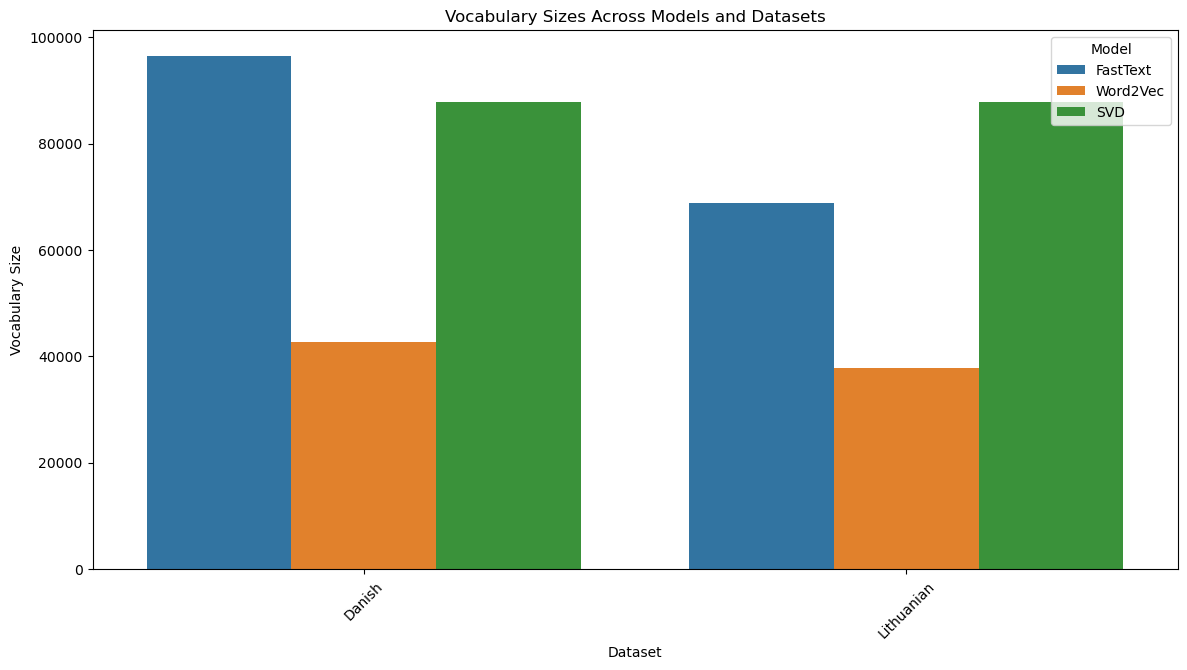

In [222]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(14, 7))
sns.barplot(x="Dataset", y="Vocabulary Size", hue="Model", data=df_vocab_sizes)
plt.title('Vocabulary Sizes Across Models and Datasets')
plt.xticks(rotation=45)
plt.show()